<a href="https://colab.research.google.com/github/AlirezaPNouri/Papers/blob/main/nytComprehensiveCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this comprehensive code, all the steps of CoRBS are included. 11/12/2022 

In [1]:
#install needed packages
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.2 MB/s 
     |████████████████████████████████| 182 kB 92.4 MB/s 
     |████████████████████████████████| 7.6 MB 84.0 MB/s 


In [55]:
#Import needed packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy import median, array, exp
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from transformers import BertTokenizer, TFBertModel
import copy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import requests
import string
import tensorflow as tf
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
#Download needed packages
nltk.download('punkt')

#### Load the pre-traiend BERT model #####################
##########################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#load needed objects

In [4]:
#constant variables
dataset_NYT_link = 'drive/MyDrive/temp/data_last_version/newyorktimes_2018.p'
dataset_percentage = 1
# MAX_DATA = 100
# doc_list =[item for item in range(MAX_DATA)]
MAX_SENTENCE_LENGTH = 350
MIN_SENTENCE_LENGTH = 200
jump = 3 # jump size for gradient decent
MAX_FEATURE_SIZE = 20 # max size of the gradient descent vector
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
threshold_cluster_overlapping = 0.7 # to consider two clsuters are similar
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']




In [5]:
# download the dataset as a zip file from the git repo
def dataset_downloader(str_):
  """
  This function download a dataset
  Arguments:
    str_: the name of the dataset. It can be covid or NYT
  Returns:
    df: a pandas dataframe
  """
  df = pickle.load(open(dataset_NYT_link, 'rb'))
  print('dataset size before removing non-value cells is {}'.format(df.shape))
  df.columns = ['id', 'title', 'author', 'date', 'content']
  df = df.dropna(how='any', axis=0)
  print('dataset size after removing non-value cells is {}'.format(df.shape))
  # reduce the size of dataset to dataset_percentage*dataset.shape
  # df = df.sample(frac=dataset_percentage)
  print('The new size of dataset is {} and the columns are {}'.format(df.shape, df.columns.values ))
  # remove the content that has less than MIN_SENTENCE_LENGTH words 
  df = df[df['content'].apply(lambda x : len(x.split(' ')))>=MIN_SENTENCE_LENGTH]

  # keep the first 500 words in content
  df['content'] = df['content'].apply(lambda x : ' '.join(x.split(' ')[:MAX_SENTENCE_LENGTH]))
  return df


In [ ]:
# today_covid_df = dataset_downloader('covid')
# today_nyt_df = dataset_downloader('NYT')

In [6]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [7]:
### create embedding vector for each token in each document
def bert_embedding_generator(df_):
  """
  Generate the embedding for a document
  Arguments:
    df_: a pandas dataframe 
  Returns:
    Embedding_dict: a dictionary of document indices and [embedding vectors, content]
  """
  Embedding_dict = dict()
  # print('Start to generate the embedding vector for documents')
  c = 0
  for index, row in df_.iterrows():
    content_ = row['content']
    tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
    tmp_d = tokenizer.tokenize(content_)
    temp_dict = dict()
    temp_dict['cls'] = tmp_e[0]
    for emb, tok in zip(tmp_e[1:-1], tmp_d):
      temp_dict[tok] = emb
    temp_dict['sep'] = tmp_e[-1]
    Embedding_dict[row['id']] = temp_dict
    c +=1
  # print('Embedding is done for {} documents.'.format(c))
  return Embedding_dict

In [8]:
# ### Create a list of dataframe out of the dataset. Each dataframe belongs to a timestamp #############
# ######################################################################################################
# # use 10 days as time interval
# def timestamps_generator(df_n):
#   """
#   This function collect data related to each timestamp separately in a dataframe
#   Arguments:
#     df_: a pandas dataframe
#   Returns:
#     df_list: a list of all timestamps data [df_1, df_2, ...]
#   """
#   time_stamp = set()
#   df_list= list()
#   for index, row in df_n.iterrows():
#     time_stamp.add(row['publish_time'][0:4])
#   # this is the new line added by ali at 11/08/2022
#   time_stamp = sorted(time_stamp)
#   # this is the new line added by ali at 11/08/2022
#   for time_interval in time_stamp:
#     new_df = df_n[df_n['publish_time'].str.slice(0, 4)== time_interval]
#     if new_df.shape[0]>5: #minimum number of doc in a timestamp
#       df_list.append(new_df)
#   return df_list


def timestamps_generator(df_n):
  """
  This function collect data related to each timestamp separately in a dataframe
  Arguments:
    df_: a pandas dataframe
  Returns:
    df_list: a list of all timestamps data [df_1, df_2, ...]
  """
  time_stamp = set()
  df_list= list()
  for index, row in df_n.iterrows():
    time_stamp.add(row['publish_time'][0:4])
  # this is the new line added by ali at 11/08/2022
  time_stamp = sorted(time_stamp)
  # this is the new line added by ali at 11/08/2022
  for time_interval in time_stamp:
    new_df = df_n[df_n['publish_time'].str.slice(0, 4)== time_interval]
    if new_df.shape[0]>5: #minimum number of doc in a timestamp
      df_list.append(new_df)
  new_df_list = list()
  for tt in range(0, len(df_list)-1, 2):
    new_df_list.append(pd.concat([df_list[tt], df_list[tt+1]]))
  return new_df_list

In [9]:
def time_fixer(str_):
  """
  This function convert a date from x/x/xxxx to 0x0xxxxx
  Arguments:
    str_: a date in a string format
  Returns:
    a string without any / and all months and days are in two digit
  """
  t_slot = str_.split('/')
  t_slot[0] = t_slot[0] if len(t_slot[0]) == 2 else '0'+t_slot[0]
  t_slot[1] = t_slot[1] if len(t_slot[1]) == 2 else '0'+t_slot[1]
  return ''+t_slot[0]+t_slot[1]+t_slot[2]

In [ ]:
# print(time_fixer(today_nyt_df['publish_time'].iloc[10]))
# print(time_fixer(today_covid_df['publish_time'].iloc[10]))

In [10]:
def find_similarity(Embed_):
  """
  This function calculate the cosine similarity between each pair of words in a document and sort them as a new vector
  Arguments:
    Embed_: a dictionary of all doc and embedding seperated into their timestamps {timestamp1 {doc1{token1: embedding, token2: embedding}}}
  Returns:
    neighbor_ts_doc: a dictionary of all timestamps, docs and the neighbor similarity for each word
  """
  tmp_collector = dict()
  neighbor_ts_doc = dict()
  for ts_ in tqdm(Embed_.keys()):
    temp = Embed_[ts_]
    final_list = dict()
    for doc in temp.keys():
      if doc in tmp_collector.keys():
        final_list[doc] = tmp_collector[doc]
      else:
        neighbor_dict = dict()
        track_dict = dict()
        
        for f_word, f_emb in temp[doc].items():
          temp_list = list()
          
          for s_word, s_emb in temp[doc].items():
            if (s_word, f_word) in track_dict.keys():
              temp_list.append(track_dict[(s_word, f_word)])
            else:
              track_dict[(f_word, s_word)] = cosine_similarity([f_emb],[s_emb])[0][0]
              temp_list.append(track_dict[(f_word, s_word)])
          
          neighbor_dict[f_word] =sorted(temp_list, reverse=True)[1:] # ignore the cosine similarity between a word and itself

        final_list[doc] = neighbor_dict
        tmp_collector[doc] = neighbor_dict

      # print('Document {} is done!'.format(doc))
    neighbor_ts_doc[ts_] = final_list
  return neighbor_ts_doc

In [11]:

#sigmoid function
def amplifier_function(vec_):
  """
  This function receives a vector and applies the curve below to reward the first part of the vector and to penalize the last part of the vector
  Arguments:
    vec_: a vector
  Results:
    g: a vector
  """
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

In [12]:
def gradient_calculator(ns_dict, n_step, MAX_FEATURE_SIZE):
  """
  This function receives all the similarity neighbor for each word in all documents and apply gradient descent over them by the step
  Arguments:
    ns_dict: a dictinary of all neighbor similarity for all tokens
    n_step: the jump value for gradient discent
    MAX_FEATURE_SIZE: the maximum size for each feature victor
  Returns:
    final_dict: a dictionary of all gradient discent of tokens neighbor similarity
  """
  final_dict = dict()
  for ts_ in tqdm(ns_dict.keys()):
    gradient_descent_neighbors = dict()
    word_neighbor_similarity = ns_dict[ts_]
    for doc in word_neighbor_similarity.keys():
      temp_dict = dict()
      for word, embedding in word_neighbor_similarity[doc].items():
        vec_size = len(embedding)
        vec_size -= vec_size%n_step
        embedding = embedding[0:vec_size]
        new_list = [embedding[x:x+n_step] for x in range(0, vec_size, n_step)]
        tmp_list = list()
        for ele in new_list:
          m1,b1 = np.polyfit(np.arange(0, n_step), ele, 1)
          tmp_list.append(m1)
        temp_dict[word] = amplifier_function(tmp_list[0:MAX_FEATURE_SIZE])
      gradient_descent_neighbors[doc] = temp_dict
      # print('Document {} is done!'.format(doc))
    final_dict[ts_] = gradient_descent_neighbors
  return final_dict

In [13]:

# clustering the tokens in each document. It creates differnt number of clustering

def cluster_maker(final_vec_):
  """
  This function generates clusters based on featur vectors
  Arguments:
    final_vec_: a dictionary of all gradient discent of tokens neighbor similarity
  Returns:
    total_clustering: a dictionary contains timestamps and clusters in each timestamp 
    total_centroid: a dictionart contains timestamps and centroids for each clusters
  """
  total_clustering = dict()
  total_centroid = dict()
  for ts_ in tqdm(final_vec_.keys()):
    gradient_descent_neighbors = final_vec_[ts_]
    all_clusters = dict()
    all_centroid = dict()
    for doc, featurs in gradient_descent_neighbors.items():
      clusters_per_doc = dict()
      centroids_per_doc = dict()
      for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=100,)
        clusters_per_doc[n_clusters] = clusterer.fit_predict(list(featurs.values()))
        centroids_per_doc[n_clusters] = clusterer.cluster_centers_
      all_clusters[doc] = clusters_per_doc
      all_centroid[doc] = centroids_per_doc
      # print('Document {} is done!'.format(doc))
    total_clustering[ts_] = all_clusters
    total_centroid[ts_] = all_centroid
  return total_clustering, total_centroid
    

In [14]:
def sorted_clustering(all_gradient_descent_neighbors,all_clusters_dict, all_centroids_dict):
  final_clustering_dict = dict()
  for ts_ in tqdm(all_clusters_dict.keys()):
    gradient_descent_neighbors = all_gradient_descent_neighbors[ts_]
    all_centroid = all_centroids_dict[ts_]
    all_clusters = all_clusters_dict[ts_]
    #create a total clusters sorted dictionary
    ## the structure of total_docs_clusters  is {doc0: {number_of_clusters { cluster_number: {token0: closeness_to_centroid, token1: closeness_to_centroid ...} }}}
    total_docs_clusters = dict()
    for doc in all_clusters.keys():
      temp_cluster = all_clusters[doc]
      dic_for_clustering = dict()
      for n_cluster in range_n_clusters:
        temp_dict = dict()
        for la in range(n_cluster):
          temp_list = dict()
          for label_, value_ in zip(temp_cluster[n_cluster],gradient_descent_neighbors[doc].items()):
            if label_ == la:
              temp_list[value_[0]] = np.sum(np.square(value_[1] - all_centroid[doc][n_cluster][la]))
          temp_dict[la]=temp_list
        dic_for_clustering[n_cluster] = temp_dict
      total_docs_clusters[doc] = dic_for_clustering
      # print('Document {} is done!'.format(doc))
    final_clustering_dict[ts_] = total_docs_clusters
  return final_clustering_dict

In [15]:
def similar_doc(doc_one, doc_two):
  """
  #find similar documents
  """
  list_sim = list()
  for clu_1 in doc_one:
    total_jac = 0
    for clu_2 in doc_two:
      jac_val = jaccard_similarity(clu_1, clu_2)
      total_jac += jac_val
    # total_jac /= len(doc_two)
    list_sim.append(total_jac)
  return sum(list_sim)
  # return sum(list_sim)/(len(doc_one)*len(doc_two))   #with normalizing based on the number of word groups

def similar_doc_a(doc_one, doc_two):

  list_sim = list()
  for clu_1 in doc_one:
    total_jac = 0
    for clu_2 in doc_two:
      jac_val = jaccard_similarity(clu_1.keys(), clu_2.keys())
      total_jac += jac_val
    # total_jac /= len(doc_two)
    list_sim.append(total_jac)
  return 1- np.average(list_sim)

In [16]:
def normalize_vec(vec, min_, max_):
  """
  # this function will receive a vector and the min and max of that vector and will return the normalized vec 
  """
  range_val = (max_ - min_)+0.0000001
  vec = [item/range_val for item in vec]
  min_vec = min(vec)
  vec = [item - min_vec for item in vec]
  return vec



def normalize_value(item, min_, max_):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  range_val = (max_ - min_)+0.0000001
  vec = (item-min_)/range_val
  return vec
def normalize_value_(vec):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  min_ = min(vec.values())
  max_ = max(vec.values())
  range_val = (max_ - min_)+0.0000001
  for doc in vec.keys():
    vec[doc] = (vec[doc] - min_) /range_val

  return vec

In [17]:
def normalizer(total_docs_clustering_):
  """
    normalize the similarity in each cluster. It goes and find the min and max values in each clustering and make those similarity between [0,1] (the similarity here is euclidean distance between each token and the centroid)

  """
  all_total_docs_clusters = dict()
  for ts_ in tqdm(total_docs_clustering_.keys()):
    total_docs_clusters = total_docs_clustering_[ts_]
    for doc in total_docs_clusters.keys():
      temp_doc = total_docs_clusters[doc]
      for cluster_rank in temp_doc.keys():
        temp_clustering = temp_doc[cluster_rank]
        min_sim = 1
        max_sim = 0
        for ind in temp_clustering.keys():
          for ele, val_ in temp_clustering[ind].items():
            min_sim = min_sim if min_sim<val_ else val_
            max_sim = max_sim if val_<max_sim else val_ 

        for ins in temp_clustering.keys():
          for el in total_docs_clusters[doc][cluster_rank][ins].keys():
            total_docs_clusters[doc][cluster_rank][ins][el] = normalize_value(total_docs_clusters[doc][cluster_rank][ins][el], min_sim, max_sim)
      # print('Document {} is done!'.format(doc))
    all_total_docs_clusters[ts_] = total_docs_clusters
  return all_total_docs_clusters

In [18]:
def stopword_remover(all_dict_):
  final_dict_w_stopword = dict()
  for ts_ in all_dict_.keys():
    total_docs_clusters = all_dict_[ts_]
    #remove stopwords
    total_docs_clusters_wo_stopwords = dict()
    for doc in total_docs_clusters.keys():
      temp_doc = {}
      for cluster_rank in total_docs_clusters[doc].keys():
        temp_clustering = {}
        for ins in total_docs_clusters[doc][cluster_rank].keys():
          temp_cluster = {}
          for items in total_docs_clusters[doc][cluster_rank][ins].items():
            if items[0] not in stopwords:
              temp_cluster[items[0]] = items[1]
          temp_clustering[ins] = temp_cluster
        temp_doc[cluster_rank] = temp_clustering
      total_docs_clusters_wo_stopwords[doc] = temp_doc
    final_dict_w_stopword[ts_] = total_docs_clusters_wo_stopwords
  return final_dict_w_stopword

In [19]:
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))

In [20]:
# def word_group_generator(all_clusters_):
#   final_total_doc_word_group = dict()
#   for ts_ in tqdm(all_clusters_.keys()):
#     total_docs_clusters_wo_stopwords = all_clusters_[ts_]
#     total_doc_word_groups = dict()
#     for doc in total_docs_clusters_wo_stopwords.keys():
#       docs_clusters = total_docs_clusters_wo_stopwords[doc]
#       # print(docs_clusters)
#       temp_list_word_groups = list()
#       for cluster_num in list(docs_clusters.keys())[:-1]:
#         for cluster in range(cluster_num):
#           for next_cluster in range(cluster_num+1):
#             cl1 = list()
#             cl1_w_sim = dict()
#             cl2 = list()
#             cl2_w_sim = dict()
#             joint_list = list()
#             for item in docs_clusters[cluster_num][cluster].items():
#               cl1.append(item[0])
#               cl1_w_sim[item[0]] =  item[1]
#             for another_item in docs_clusters[cluster_num+1][next_cluster].items():
#               cl2.append(another_item[0])
#               cl2_w_sim[another_item[0]] = another_item[1]
#             # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
#             jac_val = jaccard_similarity(cl1, cl2)
#             if jac_val > threshold_cluster_overlapping:
#               jnt_list = list(set(cl1).intersection(cl2))
#               dict_vocab = dict()
#               for el in jnt_list:
#                 dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

#               temp_list_word_groups.append([dict_vocab ,jac_val])
      

#       total_doc_word_groups[doc] = temp_list_word_groups
#       # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
#     final_total_doc_word_group[ts_] = total_doc_word_groups
#   return final_total_doc_word_group


def word_group_generator(all_clusters_):
  total_docs_clusters_wo_stopwords = all_clusters_
  total_doc_word_groups = dict()
  for doc in total_docs_clusters_wo_stopwords.keys():
    docs_clusters = total_docs_clusters_wo_stopwords[doc]
    # print(docs_clusters)
    temp_list_word_groups = list()
    for cluster_num in list(docs_clusters.keys())[:-1]:
      for cluster in range(cluster_num):
        for next_cluster in range(cluster_num+1):
          cl1 = list()
          cl1_w_sim = dict()
          cl2 = list()
          cl2_w_sim = dict()
          joint_list = list()
          for item in docs_clusters[cluster_num][cluster].items():
            cl1.append(item[0])
            cl1_w_sim[item[0]] =  item[1]
          for another_item in docs_clusters[cluster_num+1][next_cluster].items():
            cl2.append(another_item[0])
            cl2_w_sim[another_item[0]] = another_item[1]
          # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
          jac_val = jaccard_similarity(cl1, cl2)
          if jac_val > threshold_cluster_overlapping:
            jnt_list = list(set(cl1).intersection(cl2))
            dict_vocab = dict()
            for el in jnt_list:
              dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

            temp_list_word_groups.append([dict_vocab ,jac_val])
    

    total_doc_word_groups[doc] = temp_list_word_groups
      # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
    
  return total_doc_word_groups


In [21]:
# def distance_2_freq(all_clusters_):
#   """
#   change the distance to centroid to the frequency [0, 1] --> [10, 1] 
#   """
#   final_dict = dict()
#   for ts_ in tqdm(all_clusters_.keys()):
#     total_doc_word_groups_ = all_clusters_[ts_]
#     #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
#     for doc in total_doc_word_groups_.keys():
#       temp_list = list()
#       for word_list in total_doc_word_groups_[doc]:
#         temp_dict = dict()
#         for ele in word_list[0].keys():
#           temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
#         temp_list.append(temp_dict)
#       total_doc_word_groups_[doc] = temp_list
#     final_dict[ts_] = total_doc_word_groups_
#   return final_dict
#     # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency}


def distance_2_freq(all_clusters_):
  """
  change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  """

  total_doc_word_groups_ = all_clusters_
  #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  for doc in total_doc_word_groups_.keys():
    temp_list = list()
    for word_list in total_doc_word_groups_[doc]:
      temp_dict = dict()
      for ele in word_list[0].keys():
        temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
      temp_list.append(temp_dict)
    total_doc_word_groups_[doc] = temp_list

  return total_doc_word_groups_
    # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency} 

In [22]:
def bert_classifier_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based on BERT cls vector             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  total_dict = dict()
  for doc_1 in tqdm(total_doc_word_embedding.keys()):
    temp_dict = dict()
    for doc_2 in total_doc_word_embedding.keys():
      if doc_1 != doc_2:
        temp_dict[doc_2] =np.linalg.norm(total_doc_word_embedding[doc_1]['cls']-total_doc_word_embedding[doc_2]['cls'])
    total_dict[doc_1] = temp_dict
    # print('Document {} is done!'.format(doc_1))
  return total_dict  

In [23]:
# def similarity_documents(all_dict_):
#   """
#     calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
#     the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
#   """
#   total_dict_ = dict()
#   for ts_ in tqdm(all_dict_.keys()):
#     total_doc_word_groups_ = all_dict_[ts_]
#     total_clustering_w_frequency = dict()
#     for doc in total_doc_word_groups_.keys():
#       list_word_cloud = list()
#       for word_group in total_doc_word_groups_[doc]:
#         temp_list = list()
#         for word in word_group.items():
#           for ind in range(1, word[1]+1):
#             temp_list.append(word[0])
#         list_word_cloud.append(temp_list)
#       total_clustering_w_frequency[doc] = list_word_cloud
#       # print('document {} is done!'.format(doc))
#     total_dict_[ts_] = total_clustering_w_frequency
#   return total_dict_
def similarity_documents(all_dict_):
  """
    calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
    the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
  """

  total_doc_word_groups_ = all_dict_
  total_clustering_w_frequency = dict()
  for doc in tqdm(total_doc_word_groups_.keys()):
    list_word_cloud = list()
    for word_group in total_doc_word_groups_[doc]:
      temp_list = list()
      for word in word_group.items():
        for ind in range(1, word[1]+1):
          temp_list.append(word[0])
      list_word_cloud.append(temp_list)
    total_clustering_w_frequency[doc] = list_word_cloud
    # print('document {} is done!'.format(doc))

  return total_doc_word_groups_

In [24]:
# def weight_matrix_generator(all_dict_):
#   final_dict_ = dict()
#   for ts_ in tqdm(all_dict_.keys()):
#     total_clustering_w_frequency_ = all_dict_[ts_]
#     #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
#     doc_matrix=dict()
#     for first_doc in total_clustering_w_frequency_.keys():
#       temp_dict = dict()
#       for second_doc in total_clustering_w_frequency_.keys():
#         if first_doc != second_doc:
#           temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
#       doc_matrix[first_doc] = temp_dict
#       # print('Document {} is done'.format(first_doc))
    
#     #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low

#     for doc in doc_matrix.keys():
#       min_ = 10000
#       max_ = -10000
#       for ele in doc_matrix[doc].items():
#         min_ = min_ if min_<ele[1] else ele[1]
#         max_ = max_ if max_> ele[1] else ele[1]
#       for ele in doc_matrix[doc].keys():
#         doc_matrix[doc][ele] = int(99*(1-normalize_value(doc_matrix[doc][ele], min_, max_))+1)

#     final_dict_[ts_]= doc_matrix
#   return final_dict_
def weight_matrix_generator(all_dict_):
  total_clustering_w_frequency_ = all_dict_
  #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
  doc_matrix=dict()
  for first_doc in tqdm(total_clustering_w_frequency_.keys()):
    temp_dict = dict()
    for second_doc in total_clustering_w_frequency_.keys():
      if first_doc != second_doc:
        temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
    doc_matrix[first_doc] = temp_dict
    # print('Document {} is done'.format(first_doc))
  
  #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low
  print('Start normalize the vectors')
  for doc in doc_matrix.keys():
    doc_matrix[doc] = normalize_value_(doc_matrix[doc])

  return doc_matrix

def weight_matrix_generator_a(all_dict_):
  total_clustering_w_frequency_ = all_dict_
  #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
  doc_matrix=dict()
  for first_doc in tqdm(total_clustering_w_frequency_.keys()):
    temp_dict = dict()
    for second_doc in total_clustering_w_frequency_.keys():
      if first_doc != second_doc:
        temp_dict[second_doc] = similar_doc_a(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
    doc_matrix[first_doc] = temp_dict
    # print('Document {} is done'.format(first_doc))
  
  #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low
  print('Start normalize the vectors')
  for doc in doc_matrix.keys():
    doc_matrix[doc] = normalize_value_(doc_matrix[doc])

  return doc_matrix


In [25]:
# A*Search algorithm

from collections import deque

class Graph:

    def __init__(self,heuristic, adjacency_list, start_node, stop_node):
        self.adjacency_list = adjacency_list
        self.H = dict()
        self.start_node = start_node
        self.stop_node = stop_node
        self.heuristic = heuristic
        for ele in heuristic[stop_node]:
          self.H[ele[0]] = ele[1]
        # self.H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
      
    # def get_neighbors(self, v):
    #     return self.adjacency_list[v]
    # # heuristic function with equal values for all nodes
    
    # def h(self, n):
    #   # H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
    #   return self.H[n]
    def a_star_algorithm(self):

      # open_list is a list of nodes which have been visited, but who's neighbors
      # haven't all been inspected, starts off with the start node
      # closed_list is a list of nodes which have been visited
      # and who's neighbors have been inspected
      open_list = set([self.start_node])
      closed_list = set([])
      # g contains current distances from start_node to all other nodes
      # the default value (if it's not found in the map) is +infinity
      g = {}
      g[self.start_node] = 0
      # parents contains an adjacency map of all nodes
      parents = {}
      parents[self.start_node] = self.start_node
      while len(open_list) > 0:
          n = None
          # find a node with the lowest value of f() - evaluation function
          for v in open_list:
              if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
              # if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
                  n = v;
          if n == None:
              print('Path does not exist!')
              return None
          # if the current node is the stop_node
          # then we begin reconstructin the path from it to the start_node
          if n == self.stop_node:
              reconst_path = []
              while parents[n] != n:
                  reconst_path.append(n)
                  n = parents[n]
              reconst_path.append(self.start_node)
              reconst_path.reverse()
              print('Path found: {}'.format(reconst_path))
              return reconst_path
          # for all neighbors of the current node do
          for (m, weight) in self.adjacency_list[n]:
              # if the current node isn't in both open_list and closed_list
              # add it to open_list and note n as it's parent
              avr = 0
              sam = 0
              for t in self.heuristic[n]: 
                  avr += t[1]
                  if t[0] == m:
                    sam = t[1]
              if sam > avr/2:
                  continue
              if m not in open_list and m not in closed_list:
                  open_list.add(m)
                  parents[m] = n
                  g[m] = g[n] + weight
              # otherwise, check if it's quicker to first visit n, then m
              # and if it is, update parent data and g data
              # and if the node was in the closed_list, move it to open_list
              else:
                  if g[m] > g[n] + weight:
                      g[m] = g[n] + weight
                      parents[m] = n
                      if m in closed_list:
                          closed_list.remove(m)
                          open_list.add(m)
          # remove n from the open_list, and add it to closed_list
          # because all of his neighbors were inspected
          open_list.remove(n)
          closed_list.add(n)

      print('Path does not exist!')
      return None

In [26]:
def a_search(all_embedding, all_weight):
  result_dict = dict()
  for ts_ in all_embedding.keys():
    doc_embedding_ = all_embedding[ts_]
    doc_matrix_ = all_weight[ts_]
    start_ = list(doc_embedding_.keys())[0]
    end_ = list(doc_embedding_.keys())[-1]
    #create the adjacancy matrix from the euclidean distanse of the doc embedding
    #heuristic

    heuristic = dict()
    for first_doc in doc_embedding_.keys():
      temp_list = list()
      for second_doc in doc_embedding_.keys():
        if first_doc != second_doc:
          temp_list.append((second_doc, doc_embedding_[first_doc][second_doc]))
        else:
          temp_list.append((second_doc, 0))
      heuristic[first_doc] = temp_list
    # print('heuristic is ', heuristic)

    # the weights
    doc_weights = dict()
    for first_doc in doc_matrix_.keys():
      temp_dict = list()
      for second_doc in doc_matrix_.keys():
        if first_doc != second_doc:
          temp_dict.append((second_doc, doc_matrix_[first_doc][second_doc]))
      doc_weights[first_doc] = temp_dict
    # print('weights is ', doc_weights)
    graph1 = Graph(heuristic, doc_weights, start_, end_)
    result_dict[ts_] = graph1.a_star_algorithm()
    print('Timestamp {} is done!'.format(ts_))
  return result_dict

In [27]:
def merging_df(list_df_):
  new_df_list = list()
  for n in range(len(list_df_)-1):
    frames = [list_df_[n], list_df_[n+1]]
    new_df_list.append(pd.concat(frames))
  new_df_list.append(list_df_[n+1])
  return new_df_list



In [28]:
def get_df_size(list_of_df_):
  tmp_list = list()
  for df_ in list_of_df_:
    tmp_list.append(len(list(df_['id'])))
  return tmp_list

In [29]:
df = dataset_downloader('NYT')
print(df.columns)
df['content'] = df['content'].apply( lambda x: special_char_remover(x)) # remove special characters

df['publish_time'] = df['date'].apply(lambda x: time_fixer(x))
list_of_dfs = timestamps_generator(df)
print('before merging dfs: ' ,get_df_size(list_of_dfs))
list_of_timestamps = [list(x['id']) for x in list_of_dfs ]
list_of_dfs = merging_df(list_of_dfs)  # merging two coonsecuative df to each other and made a new one 
print('after merging dfs: ',get_df_size(list_of_dfs))

dataset size before removing non-value cells is (1196, 5)
dataset size after removing non-value cells is (1184, 5)
The new size of dataset is (1184, 5) and the columns are ['id' 'title' 'author' 'date' 'content']
Index(['id', 'title', 'author', 'date', 'content'], dtype='object')
before merging dfs:  [24, 24, 29, 26, 30, 44, 13, 30, 29, 24, 31, 42, 22, 24, 39, 37, 12, 26, 25, 23, 38, 37, 25, 24, 23, 23, 21, 25, 27, 17, 26, 32, 34, 12, 32, 28, 23, 28, 29, 19, 19, 26, 21]
after merging dfs:  [48, 53, 55, 56, 74, 57, 43, 59, 53, 55, 73, 64, 46, 63, 76, 49, 38, 51, 48, 61, 75, 62, 49, 47, 46, 44, 46, 52, 44, 43, 58, 66, 46, 44, 60, 51, 51, 57, 48, 38, 45, 47, 21]


In [ ]:
# id_df = set()
# id_ts = set()
# for ts in list_of_timestamps:
#   for t in ts:
#     id_ts.add(t)
# for dd in list_of_dfs:
#   for d, l in dd.iterrows():
#     id_df.add(l['id'])

# for t in id_df:
#   if t not in id_ts:
#     print(t)

In [30]:
# pickle.dump(list_of_dfs, open('drive/MyDrive/temp/data_last_version/nyt_list_of_dfs.p', 'wb'))
# pickle.dump(list_of_timestamps, open('drive/MyDrive/temp/data_last_version/nyt_list_of_timestamps.p', 'wb'))
# pickle.dump(df, open('drive/MyDrive/temp/data_last_version/nyt_df.p', 'wb'))

list_of_dfs = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_list_of_dfs.p', 'rb'))
list_of_timestamps = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_list_of_timestamps.p', 'rb'))
df = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_df.p', 'rb'))

In [ ]:
# #test the order of timestamps and published time
# today_list = list()
# for time_id in list_of_timestamps:
#   for doc_id in time_id:
#     today_set = set()
#     temp = df[df['id']== doc_id]['publish_time']
#     # print(str(temp).split()[1])
#     today_set.add(str(temp).split()[1])
#   today_list.append(sorted(today_set))
# print(today_list[0:20])
# print(today_list[20:40])
# print(today_list[40:60])
# print(today_list[60:])

In [ ]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}
for ts, data_ in tqdm(zip(range(len(list_of_dfs)), list_of_dfs)):
   Embed_dict[ts] = bert_embedding_generator(data_)


43it [09:00, 12.57s/it]


In [ ]:

# list_of_docs = set()
# list_of_ts_docs = set()
# for ke in Embed_dict.keys():
#   for tt in Embed_dict[ke].keys():
#     list_of_docs.add(tt)
# print(len(list_of_docs))
# for ts_s in list_of_timestamps:
#   for t_i in ts_s:
#     list_of_ts_docs.add(t_i)
# print(len(list_of_ts_docs))

# for t in list_of_docs:
#   if t not in list_of_ts_docs:
#     print(t)

1143
1143


In [ ]:
final_vector = find_similarity(Embed_dict)

100%|██████████| 43/43 [1:42:26<00:00, 142.93s/it]


In [ ]:
final_vector = gradient_calculator(final_vector, jump, MAX_FEATURE_SIZE)

100%|██████████| 43/43 [41:05<00:00, 57.34s/it]


In [ ]:
total_clustering, total_centroid = cluster_maker(final_vector)

100%|██████████| 43/43 [05:00<00:00,  7.00s/it]


In [ ]:
total_docs_clustering = sorted_clustering(final_vector, total_clustering, total_centroid)

100%|██████████| 43/43 [00:30<00:00,  1.39it/s]


In [ ]:
normalized_total_docs_clusters = normalizer(total_docs_clustering)

100%|██████████| 43/43 [00:01<00:00, 23.76it/s]


In [ ]:
total_docs_clusters_wo_stopwords = stopword_remover(normalized_total_docs_clusters)

In [ ]:
total_doc_clusters = dict()
for ts_ in total_docs_clusters_wo_stopwords.keys():
  for doc in total_docs_clusters_wo_stopwords[ts_].keys():
    total_doc_clusters[doc] = total_docs_clusters_wo_stopwords[ts_][doc]

In [ ]:
total_doc_embedding = dict()
for t_ in Embed_dict.keys():
  for doc in Embed_dict[t_].keys():
    total_doc_embedding[doc] = Embed_dict[t_][doc]

In [ ]:
# # for t in final_vector.keys():
# #   print(len(final_vector[t]))
# print(sum([len(final_vector[t]) for t in range(len(final_vector.keys()))]))

2862


In [ ]:
total_doc_word_groups = word_group_generator(total_doc_clusters)

In [ ]:
total_doc_word_groups = distance_2_freq(total_doc_word_groups)

In [ ]:
total_clustering_w_frequency = similarity_documents(total_doc_word_groups)

NameError: ignored

In [37]:
# doc_matrix_weight = weight_matrix_generator(total_clustering_w_frequency)
doc_matrix_weight = weight_matrix_generator_a(total_clustering_w_frequency)
#zero values means matched, 1 means not matched

100%|██████████| 1143/1143 [11:45<00:00,  1.62it/s]


Start normalize the vectors


In [43]:
print(total_clustering_w_frequency[237366])
print(doc_matrix_weight[248238][264005])
print(doc_matrix_weight[248238][253155])

[{'ve': 8, 'become': 9, 'ritual': 9, 'health': 9, 'easy': 9, '##ing': 9, 'us': 9, 'day': 9, 'sleeping': 9, '##ich': 9, 'reason': 9, 'show': 9, 'handle': 9, 'even': 9, 'advice': 9, '##bei': 9, 'guide': 9, 'doesn': 9, '##ier': 9, 'move': 9, 'physically': 9, 'seems': 9, 'mind': 8, 'something': 9, 'sep': 8, 'whatever': 9, 'often': 9, 'best': 9, '##s': 8, 'da': 9, 'combined': 9, 'much': 8, 'make': 7, 'eat': 8, 'got': 9, 'house': 9, 'comprehensive': 9, 'working': 9, 'deep': 9, 'teach': 9, 'impact': 9, 'end': 9, '##unt': 9, 'chunks': 9, 'pieces': 8, 'stay': 9, 'truly': 9, 'new': 9, 'child': 9, 'help': 9, 'home': 9, 'cr': 9, 'works': 9, 'cls': 7, 'beginnings': 9, 'really': 9, 'simple': 9, 'week': 9, 're': 9, 'result': 9, 'problem': 9, 'well': 9, 'top': 9, 'fitness': 9, 'give': 9, '##ner': 9, 'cl': 9, 'rules': 9, 'deserves': 9}, {'ritual': 9, 'become': 9, '##ing': 8, 'health': 9, 'easy': 9, 'us': 9, 'day': 9, 'sleeping': 9, '##ich': 9, 'reason': 9, 'show': 9, 'handle': 9, 'even': 9, 'advice': 9

In [ ]:
dict_similarity_bert_cls_docs = bert_classifier_generator(total_doc_embedding)

100%|██████████| 1143/1143 [03:55<00:00,  4.86it/s]


In [ ]:
for doc in dict_similarity_bert_cls_docs.keys():
  min_ = min(dict_similarity_bert_cls_docs[doc].values())
  max_ = max(dict_similarity_bert_cls_docs[doc].values())
  for sec_doc in dict_similarity_bert_cls_docs[doc].keys():
    dict_similarity_bert_cls_docs[doc][sec_doc] = (dict_similarity_bert_cls_docs[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

In [39]:
print(dict_similarity_bert_cls_docs[248238][264005])
print(dict_similarity_bert_cls_docs[248238][253155])

0.0
0.6439399365322005


In [41]:
final_weights_proposed_method = dict()
for doc in doc_matrix_weight.keys():
  temp_dict = dict()
  for sec_doc in doc_matrix_weight[doc].keys():
    temp_dict[sec_doc] = (doc_matrix_weight[doc][sec_doc] + dict_similarity_bert_cls_docs[doc][sec_doc])/2
  final_weights_proposed_method[doc] = temp_dict

In [42]:
print(final_weights_proposed_method[248238][264005])
print(final_weights_proposed_method[248238][253155])

0.05882210705721629
0.7166041986586189


In [44]:
# pickle.dump(dict_similarity_bert_cls_docs, open('drive/MyDrive/temp/data_last_version/nyt_dict_similarity_bert_cls_docs.p', 'wb'))
# pickle.dump(doc_matrix_weight, open('drive/MyDrive/temp/data_last_version/nyt_doc_matrix_weight.p', 'wb'))
# pickle.dump(total_clustering_w_frequency, open('drive/MyDrive/temp/data_last_version/nyt_total_clustering_w_frequency.p', 'wb'))
# pickle.dump(total_doc_embedding , open('drive/MyDrive/temp/data_last_version/nyt_total_doc_embedding.p', 'wb'))
# pickle.dump(Embed_dict , open('drive/MyDrive/temp/data_last_version/nyt_Embed_dict.p', 'wb'))
# pickle.dump(final_vector , open('drive/MyDrive/temp/data_last_version/nyt_final_vector.p', 'wb'))
# pickle.dump(final_weights_proposed_method, open('drive/MyDrive/temp/data_last_version/nyt_final_weights_proposed_method.p', 'wb'))


dict_similarity_bert_cls_docs = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_dict_similarity_bert_cls_docs.p', 'rb'))
doc_matrix_weight = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_doc_matrix_weight.p', 'rb'))
total_clustering_w_frequency = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_total_clustering_w_frequency.p', 'rb'))
total_doc_embedding = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_total_doc_embedding.p', 'rb'))
Embed_dict = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_Embed_dict.p', 'rb'))
final_vector = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_vector.p', 'rb'))
final_weights_proposed_method = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_weights_proposed_method.p', 'rb'))

In [45]:
weights = copy.deepcopy(final_weights_proposed_method)

In [46]:
print(weights[248238][264005])
print(weights[248238][253155])

0.05882210705721629
0.7166041986586189


In [47]:
timestamps = copy.deepcopy(list_of_timestamps)

In [48]:
def min_from_dict(sample_dict, min_d, max_d):
  min_ = 1000000
  ind = -1
  c = 0
  temp_list = sorted(sample_dict.values(), reverse=False)
  while (c < len(temp_list)):
    if temp_list[c] > min_d and temp_list[c] < max_d:
      min_ = temp_list[c]
      for ki, val in sample_dict.items():
        if val == min_:
          return [min_, ki]  # value of minimum, index of minimum
    c +=1
  return [1, -1]


def mins_from_dict(sample_dict, min_d, max_d):
  temp_list = dic_sorter(sample_dict, 10000)
  r_list = list()
  for x in temp_list:
    if (x[1] > min_d) and (x[1]<max_d):
      r_list.append(x)
  # print(min_d, max_d, r_list) 
  return r_list
  # return [x for x in temp_list if (x[1]<max_d) and (x[1] > min_d)]


In [49]:
def story_generator(weights, timestamps, start_doc, min_omega, max_omega):
  cur_ts = 0
  new_story = list()
  cur_story = start_doc
  

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story:
        temp_dict[el] = weights[cur_story][el]
    res = min_from_dict(temp_dict, min_omega, max_omega)
    if res[1] == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res[1])
      for checker in range(len(timestamps)):
        if res[1] in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res[1]
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story


def story_generator_a(weights, timestamps, start_doc, min_omega, max_omega):
  cur_ts = 0
  new_story = list()
  cur_story = start_doc
  

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story:
        temp_dict[el] = weights[cur_story][el]
    res = min_from_dict(temp_dict, min_omega, max_omega)
    if res[1] == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res[1])
      for checker in range(len(timestamps)):
        if res[1] in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res[1]
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story



In [50]:
# print(list_of_timestamps[1])
list_of_docs = set()
list_of_ts_docs = set()
for ke in weights.keys():
  list_of_docs.add(ke)
print(len(list_of_docs))
for ts_s in list_of_timestamps:
  for t_i in ts_s:
    list_of_ts_docs.add(t_i)
print(len(list_of_ts_docs))
for rt in list_of_ts_docs:
  if rt not in list_of_docs:
    print(rt)


1143
1143


In [51]:
min_omega = 0
max_omega = 1
omega_max_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
omega_max_list = [max_omega]

In [52]:
def dic_sorter(sample_dic, maximum_possible_min):
  final_list = list()
  while len(sample_dic.keys()) > 0:
      min = maximum_possible_min
      id = -1
      for key_, val_ in sample_dic.items():
          if val_ < min:
              min = val_
              id = key_
      

      final_list.append([id, min])
      del sample_dic[id]
  return final_list

Proposed Method CoRBS

In [ ]:
start_ts = 0
seed_documents = timestamps[start_ts]
min_omega = 0 # highest acceptable similarity
max_omega = 0.1 # lowest acceptable similarity


final_results_proposed = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(weights, timestamps[start_ts:], seed, min_omega, max_omega))
    # list_of_story.append(story_generator_a(weights, timestamps[start_ts:], seed, min_omega, max_omega))


    

  final_results_proposed[max_omega] = list_of_story


In [ ]:
print(*final_results_proposed[max_omega], sep = "\n")

[237366, 241221, 234398, 236740, 239548, 232233, 246287, 265420, 222528, 242731, 248427, 244390, 251129, 239742, 238686, 227825, 267644, 253603, 267950, 260984, 240208, 244757, 267826, 252373, 264096, 254144, 261196, 229658, 225564, 222360, 237427, 249693, 270305, 262821, 269560, 266444, 221974, 248722, 263574, 237314, 237847, 249755, 271361, 237350, 234166, 234963, 241836, 251205, 268767, 271528, 249591, 222306, 223249, 229985, 239681, 237709, 234603, 224195, 261532, 244159, 225826, 249793, 258842, 254079, 270486, 270556, 262083, 271505, 252184, 267000, 245184, 237675, 237048, 240452, 245146, 247869, 222111, 261287, 265688, 235986, 261634, 235624, 263580, 258713, 229127, 225746, 269748]
[235333, 238586, 245546, 232858, 232233, 246287, 265420, 222528, 242731, 248427, 244390, 251129, 239742, 238686, 227825, 267644, 253603, 267950, 260984, 240208, 244757, 267826, 252373, 264096, 254144, 261196, 229658, 225564, 222360, 237427, 249693, 270305, 262821, 269560, 266444, 221974, 248722, 263574

In [ ]:
for story_list in final_results_proposed[max_omega]:
  for doc_id in story_list:
    temp = df[df['id'] == doc_id]
    print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    # print(str(temp['id'].values[0]))

  print('------------------------------------------------------------')
  print()
  print()

237366 ,  0101 ,   9 Ways to Live Healthier in 2018  
241221 ,  0102 ,   LIGO Detects Fierce Collision of Neutron Stars for the First Time  
234398 ,  0104 ,   Expect 2018 to Be More Sane? Sorry, It s Not Going to Happen  
236740 ,  0106 ,   Cancer Doctors Cite Risks of Drinking Alcohol  
239548 ,  0108 ,   White House Immigration Demands Imperil Bipartisan Talks  
232233 ,  0110 ,   Administration Delays Prosecuting Qaeda Suspect Once Seen as Candidate for GuantÃ¡namo  
246287 ,  0111 ,   Florida Is Exempted From Coastal Drilling. Other States Ask,   Why Not Us?   
265420 ,  0112 ,   Trump s Twitter Threats Put American Credibility on the Line  
222528 ,  0112 ,   Gov. Eric Greitens of Missouri Admits Affair but Denies Threats  
242731 ,  0112 ,   Investigate an Accused Ally? New York Senate s Republican Leader Says No  
248427 ,  0114 ,   Chelsea Manning Files for Senate Run in Maryland  
244390 ,  0113 ,   Can You Convince a Landlord to Buy You Out of an Apartment?  
251129 ,  0117 

### BERT embedding story generator

In [110]:
final_results_bert = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(dict_similarity_bert_cls_docs, timestamps[start_ts:], seed, min_omega + 0.13 , max_omega))

  final_results_bert[max_omega] = list_of_story

In [111]:
print(*final_results_bert[max_omega], sep = "\n")

[239400, 259322, 241335, 249198, 257788, 255159, 262097, 224586, 247617, 249951, 264509, 257741, 257629, 252685, 228767, 237420, 243196, 253603, 252362, 247037, 240208, 262187, 245332, 228403, 229244, 254144, 231066, 261196, 258583, 255475, 232746, 231720, 240572, 268310, 232058, 256489, 248722, 263574, 256909, 256178, 249755, 225569, 224504, 268767, 264990, 233390, 229985, 241855, 252336, 233057, 239681, 224195, 234603, 233797, 251124, 265730, 244157, 248281, 234295, 258842, 270556, 223852, 225804, 226971, 229325, 243967, 226242, 260324, 266036, 267748, 259338, 226769, 238226, 221694, 257219, 225093, 231625, 269748]
[240581, 239400, 259322, 241335, 249198, 257788, 255159, 262097, 224586, 247617, 249951, 264509, 257741, 257629, 252685, 228767, 237420, 243196, 253603, 252362, 247037, 240208, 262187, 245332, 228403, 229244, 254144, 231066, 261196, 258583, 255475, 232746, 231720, 240572, 268310, 232058, 256489, 248722, 263574, 256909, 256178, 249755, 225569, 224504, 268767, 264990, 233390

In [112]:
for story_list in final_results_bert[1]:
  for doc_id in story_list:
    temp = df[df['id'] == doc_id]
    print(str(temp['publish_time'].values[0])[0:4], ':  ',str(temp['title'].values[0]))
  print('------------------------------------------------------------')
  print()
  print()

0101 :   Republican Attacks on Mueller and F.B.I. Open New Rift in G.O.P.  
0104 :   Trump s First Big Twitter Day of 2018: Analyzing Nuclear Buttons and the   Corrupt Media   
0104 :   Paul Manafort Sues Mueller and Asks a Judge to Narrow the Russia Investigation  
0104 :   Trump Says His   Nuclear Button  Is   Much Bigger  Than North Korea s  
0106 :   Toronto Theater Director Resigns Amid Sexual Misconduct Accusations  
0105 :   California Defiant in Face of Federal Move to Get Tough on Marijuana  
0105 :   Trump, Citing Pakistan as a   Safe Haven  for Terrorists, Freezes Aid  
0107 :   Republican Senators Raise Possible Charges Against Author of Trump Dossier  
0109 :   Mueller Interview With Trump Is Said to Be Likely  
0112 :   Right and Left React to the Extension of Warrantless Surveillance  
0113 :   Trump Won t Visit London to Open Embassy. His U.K. Critics Say He Got the Message.  
0116 :   Calls to Investigate State Senator Persist. But Will It Happen?  
0118 :   He Leaked 

In [113]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))



------------ 1 -------------------


NameError: ignored

In [114]:
#generate datset from Embed_dict
dataset_list = list()
for ts_ in Embed_dict.keys():
  for doc in Embed_dict[ts_].keys():
    dataset_list.append(doc)


In [115]:
def pre_processing(sentence_, stopwords_):
  words = word_tokenize(sentence_)
  ps = PorterStemmer()
  rootWord = list()
  for w in words:
      if w not in stopwords_:
        rootWord.append(ps.stem(w))
  return ' '.join( rootWord)

In [116]:
df['clean_content'] = df['content'].apply(lambda x: pre_processing(x.lower(), stopwords))

In [117]:
# convert a dataframe to a dictionary of id and content
dataset = dict()
for index, row in df.iterrows():
  if row['id'] in dataset_list:
    dataset[row['id']] = row['clean_content']

In [118]:
def similarity_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in tqdm(total_doc_word_embedding.keys()):
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        temp_dict[second_doc] =1.0 - jaccard_similarity(total_doc_word_embedding[first_doc],total_doc_word_embedding[second_doc])
    doc_embedding[first_doc] = temp_dict
    # print('Document {} is done!'.format(first_doc) )

  return doc_embedding

100%|██████████| 1143/1143 [00:35<00:00, 32.59it/s]


In [119]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict= similarity_generator(dataset)
for doc in Embed_dict.keys():
  min_ = min(Embed_dict[doc].values())
  max_ = max(Embed_dict[doc].values())
  for sec_doc in Embed_dict[doc].keys():
    Embed_dict[doc][sec_doc] = (Embed_dict[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

100%|██████████| 1143/1143 [00:39<00:00, 29.06it/s]


### Jaccard Index storytelling generator

In [122]:
final_results_ji = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict, timestamps[start_ts:], seed, min_omega , max_omega))
  final_results_ji[max_omega] = list_of_story

In [123]:
print(*final_results_ji[1], sep = "\n")

[239400, 231583, 241335, 267241, 233925, 248242, 252133, 223708, 249951, 244390, 229708, 257629, 233687, 230072, 227120, 262289, 258676, 243308, 222095, 244757, 243481, 245810, 238085, 229933, 248126, 246543, 232458, 222965, 233030, 247325, 257740, 235934, 267718, 244655, 262314, 252739, 246470, 225353, 248726, 223249, 266571, 258272, 239125, 232074, 236122, 233390, 231508, 260872, 232760, 270023, 226276, 256341, 255013, 265695, 231042, 264326, 249091, 230552, 246579, 246656, 234576, 262641, 235477, 257431, 254580, 251257, 230045, 268355, 250989, 266177, 223668, 230664, 253871]
[240581, 241335, 267241, 233925, 248242, 252133, 223708, 249951, 244390, 229708, 257629, 233687, 230072, 227120, 262289, 258676, 243308, 222095, 244757, 243481, 245810, 238085, 229933, 248126, 246543, 232458, 222965, 233030, 247325, 257740, 235934, 267718, 244655, 262314, 252739, 246470, 225353, 248726, 223249, 266571, 258272, 239125, 232074, 236122, 233390, 231508, 260872, 232760, 270023, 226276, 256341, 255013

In [124]:
for story_list in final_results_ji[1]:
  for doc_id in story_list:
    temp = df[df['id'] == doc_id]
    print(str(temp['publish_time'].values[0])[0:4], ':  ',str(temp['title'].values[0]))
  print('------------------------------------------------------------')
  print()
  print()

0101 :   Republican Attacks on Mueller and F.B.I. Open New Rift in G.O.P.  
0102 :   Emboldened Israeli Right Presses Moves to Doom 2-State Solution  
0104 :   Paul Manafort Sues Mueller and Asks a Judge to Narrow the Russia Investigation  
0106 :   Chris Christie Interview Excerpts: The Governor on Trump, the Transition and His Record  
0108 :   J.F.K. Travelers Ask: When Can I Catch a Flight Home?  
0109 :   Iran Can t Keep Dictating Lifestyle, Its President Warns  
0111 :   Surveillance and Privacy Debate Reaches Pivotal Moment in Congress  
0112 :   New Sentences: From   The World Goes On,  by Laszlo Krasznahorkai  
0112 :   Right and Left React to the Extension of Warrantless Surveillance  
0113 :   Can You Convince a Landlord to Buy You Out of an Apartment?  
0116 :   Finding the Oldest Fossils of Butterflies Using a Human Nose Hair  
0118 :   He Leaked a Photo of Rick Perry Hugging a Coal Executive. Then He Lost His Job.  
0120 :   Facebook to Let Users Rank Credibility of News 

0


In [125]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))


------------ 1 -------------------


NameError: ignored

### Doc2vec Algorithm to generate its wn embeddings

In [126]:
tokenized_doc = []
for ind in dataset.keys():
  tokenized_doc.append(word_tokenize(pre_processing(dataset[ind], stopwords)))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
# Train the model
model = Doc2Vec(vector_size= 500, window = 5, min_count = 2, workers =4, epochs= 100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [127]:
embedding_dict= dict()
for ind in tqdm(dataset.keys()):
  embedding_dict[ind] =  model.infer_vector(dataset[ind])

100%|██████████| 1143/1143 [03:08<00:00,  6.05it/s]


In [128]:
def similarity_generator_doc2vec(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in total_doc_word_embedding.keys():
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        # temp_dict[second_doc] = cosine_similarity([total_doc_word_embedding[first_doc]],[total_doc_word_embedding[second_doc]])[0][0]
        temp_dict[second_doc] =1.0 - cosine_similarity([total_doc_word_embedding[first_doc]],[total_doc_word_embedding[second_doc]])[0][0]

    doc_embedding[first_doc] = temp_dict
    # print('Document {} is done!'.format(first_doc) )

  return doc_embedding

In [129]:
Embed_dict_doc2vec = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict_doc2vec= similarity_generator_doc2vec(embedding_dict)

In [130]:
for doc in Embed_dict_doc2vec.keys():
  min_ = min(Embed_dict_doc2vec[doc].values())
  max_ = max(Embed_dict_doc2vec[doc].values())
  for sec_doc in Embed_dict_doc2vec[doc].keys():
    Embed_dict_doc2vec[doc][sec_doc] = (Embed_dict_doc2vec[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

In [131]:
max_val = list()
for i in Embed_dict_doc2vec.keys():
  max_val.append(np.average(list(Embed_dict_doc2vec[i].values())))
print(np.average(max_val))
  # print(max(Embed_dict_doc2vec[i].values()))

0.18942165194375749


In [132]:
final_results_doc2vec = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict_doc2vec, timestamps[start_ts:], seed, min_omega-0.4, max_omega))
  final_results_doc2vec[max_omega] = list_of_story

In [133]:
print(*final_results_doc2vec[max_omega], sep = "\n")

[239400, 231583, 241221, 233707, 260994, 249198, 241335, 255159, 230547, 269063, 265861, 257385, 231912, 257318, 230300, 262726, 247435, 241532, 258205, 235851, 268931, 262911, 267826, 229628, 241220, 266553, 229771, 258356, 238086, 229658, 242298, 239848, 271493, 262331, 244171, 227369, 248239, 265209, 270072, 250374, 225569, 241836, 225708, 260696, 253767, 249902, 233797, 251124, 227575, 256398, 265730, 234295, 224390, 269835, 247869, 243102, 229325, 234985, 242790, 260199, 269795, 226309, 221694, 257219, 244284, 225742, 226660, 256420, 227874, 265533]
[240581, 269407, 249198, 241335, 255159, 230547, 269063, 265861, 257385, 231912, 257318, 230300, 262726, 247435, 241532, 258205, 235851, 268931, 262911, 267826, 229628, 241220, 266553, 229771, 258356, 238086, 229658, 242298, 239848, 271493, 262331, 244171, 227369, 248239, 265209, 270072, 250374, 225569, 241836, 225708, 260696, 253767, 249902, 233797, 251124, 227575, 256398, 265730, 234295, 224390, 269835, 247869, 243102, 229325, 234985

In [134]:
story_len_dict_proposed = list()
story_len_dict_doc2vec = list()
story_len_dict_ji = list()
story_len_dict_bert = list()
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  temp_st_4 = final_results_doc2vec[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_proposed.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_bert.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_ji.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_4:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_doc2vec.append(sum(twr)/len(twr))

------------ 1 -------------------


NameError: ignored

In [ ]:
# pickle.dump(final_results_proposed, open('drive/MyDrive/temp/data_last_version/nyt_final_results_proposed.p', 'wb'))
# pickle.dump(final_results_bert, open('drive/MyDrive/temp/data_last_version/nyt_final_results_bert.p', 'wb'))
# pickle.dump(final_results_doc2vec, open('drive/MyDrive/temp/data_last_version/nyt_final_results_doc2vec.p', 'wb'))
# pickle.dump(final_results_ji, open('drive/MyDrive/temp/data_last_version/nyt_final_results_ji.p', 'wb'))


final_results_proposed = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_results_proposed.p', 'rb'))
final_results_bert = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_results_bert.p', 'rb'))
final_results_doc2vec = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_results_doc2vec.p', 'rb'))
final_results_ji = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_final_results_ji.p', 'rb'))

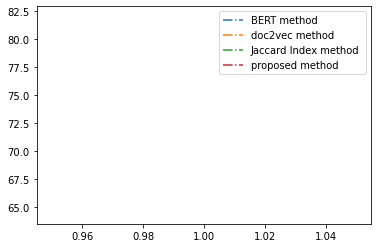

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data


y = story_len_dict_bert
x = omega_max_list
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = story_len_dict_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = story_len_dict_ji
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = story_len_dict_proposed
plt.plot(x, y, label = "proposed method ", linestyle="-." )

plt.legend()
plt.show()

In [135]:
#generate embedding for evaluation metrics
total_doc_embedding_cls = dict()
for doc in total_doc_embedding.keys():
  total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']

### Experimental Results

In [136]:
full_story_NYT_proposed_embedding = dict()
for omega in final_results_proposed.keys():
  temp_story_list = list()
  for story in final_results_proposed[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_proposed_embedding[omega] = temp_story_list

NameError: ignored

In [137]:
full_story_NYT_bert_embedding = dict()
for omega in final_results_bert.keys():
  temp_story_list = list()
  for story in final_results_bert[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_bert_embedding[omega] = temp_story_list

In [138]:
full_story_NYT_ji_embedding = dict()
for omega in final_results_ji.keys():
  temp_story_list = list()
  for story in final_results_ji[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_ji_embedding[omega] = temp_story_list

In [139]:
full_story_NYT_doc2vec_embedding = dict()
for omega in final_results_doc2vec.keys():
  temp_story_list = list()
  for story in final_results_doc2vec[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_doc2vec_embedding[omega] = temp_story_list

In [ ]:
# pickle.dump(full_story_NYT_proposed_embedding, open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_proposed_embedding.p', 'wb'))
# pickle.dump(full_story_NYT_bert_embedding, open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_bert_embedding.p', 'wb'))
# pickle.dump(full_story_NYT_ji_embedding, open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_ji_embedding.p', 'wb'))
# pickle.dump(full_story_NYT_doc2vec_embedding, open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_doc2vec_embedding.p', 'wb'))


full_story_NYT_proposed_embedding = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_proposed_embedding.p', 'rb'))
full_story_NYT_bert_embedding = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_bert_embedding.p', 'rb'))
full_story_NYT_ji_embedding = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_ji_embedding.p', 'rb'))
full_story_NYT_doc2vec_embedding = pickle.load(open('drive/MyDrive/temp/data_last_version/nyt_full_story_NYT_doc2vec_embedding.p', 'rb'))

In [140]:
def story_stretch(story_list, max_omega):
  stories = story_list[max_omega]
  stories_length = list()
  for story in stories:
    stories_length.append(len(story))
  ave = np.average(stories_length)
  return 1- np.sqrt(np.average([pow(l_i - ave,2) for l_i in stories_length])) / len(stories)

In [141]:
thre = max_omega
print('StoryStretch Metric')
print(story_stretch(final_results_proposed, thre))
print(story_stretch(final_results_bert, thre))
print(story_stretch(final_results_ji, thre))
print(story_stretch(final_results_doc2vec, thre))
# print(story_stretch(final_results_doc2vec_n, thre))

StoryStretch Metric


NameError: ignored

In [142]:
omega_list = final_results_proposed.keys()
story_stretch_proposed = [story_stretch(final_results_proposed, i) for i in omega_list]
story_stretch_bert = [story_stretch(final_results_bert, i) for i in omega_list]
story_stretch_ji = [story_stretch(final_results_ji, i) for i in omega_list]
story_stretch_doc2vec = [story_stretch(final_results_doc2vec, i) for i in omega_list]



NameError: ignored

In [143]:


x = list(omega_list)[0:-1]
plt.figure(figsize=(8,5))

y = story_stretch_proposed[0:-1]
plt.plot(x, y, label = "Our CoRBS method ", linestyle="-." )

y = story_stretch_bert[0:-1]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = story_stretch_doc2vec[0:-1]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = story_stretch_ji[0:-1]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

# y = story_stretch_doc2vec_n[0:-2]
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum Cosine similarity between pair documents')
plt.ylabel('StoryStretch')

plt.legend()
plt.show()

NameError: ignored

In [144]:
def tempo_cover(story_list, timestamp_list, omega):
  stories_list = story_list[omega]
  res = list()
  for story in stories_list:
    ts_counter = set()
    for t_s in range(len(timestamp_list)):
      for doc in story:
        if doc in timestamp_list[t_s]:
          ts_counter.add(t_s)
    res.append(len(ts_counter)/len(story))
  return np.average(res)

        



In [145]:
print('TempoCover Metric')
print(tempo_cover(final_results_proposed, list_of_timestamps, thre))
print(tempo_cover(final_results_bert, list_of_timestamps, thre))
print(tempo_cover(final_results_ji, list_of_timestamps, thre))
print(tempo_cover(final_results_doc2vec, list_of_timestamps, thre))
# print(tempo_cover(final_results_doc2vec_n, list_of_timestamps, thre))

TempoCover Metric


NameError: ignored

In [146]:
omega_list = final_results_proposed.keys()
tempo_cover_proposed = [tempo_cover(final_results_proposed, list_of_timestamps, i) for i in omega_list]
tempo_cover_bert = [tempo_cover(final_results_bert, list_of_timestamps, i) for i in omega_list]
tempo_cover_ji = [tempo_cover(final_results_ji, list_of_timestamps, i) for i in omega_list]
tempo_cover_doc2vec = [tempo_cover(final_results_doc2vec, list_of_timestamps, i) for i in omega_list]


NameError: ignored

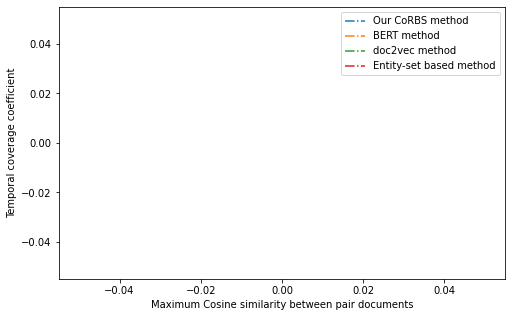

In [ ]:
x = list(omega_list)[0:-2]
plt.figure(figsize=(8,5))

y = tempo_cover_proposed[0:-2]
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )

y = tempo_cover_bert[0:-2]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = tempo_cover_doc2vec[0:-2]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = tempo_cover_ji[0:-2]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

# y = tempo_cover_doc2vec_n[0:-2]
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum Cosine similarity between pair documents')
plt.ylabel('Temporal coverage coefficient')

plt.legend()
plt.show()

In [ ]:
# #generate embedding for evaluation metrics


# total_doc_embedding = dict()
# for t_ in Embed_dict.keys():
#   for doc in Embed_dict[t_].keys():
#     total_doc_embedding[doc] = Embed_dict[t_][doc]


# total_doc_embedding_cls = dict()
# for doc in total_doc_embedding.keys():
#   total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']


# full_story_NYT_proposed_embedding = dict()
# for omega in final_results_proposed.keys():
#   temp_story_list = list()
#   for story in final_results_proposed[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_proposed_embedding[omega] = temp_story_list


# full_story_NYT_bert_embedding = dict()
# for omega in final_results_bert.keys():
#   temp_story_list = list()
#   for story in final_results_bert[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_bert_embedding[omega] = temp_story_list


# full_story_NYT_ji_embedding = dict()
# for omega in final_results_ji.keys():
#   temp_story_list = list()
#   for story in final_results_ji[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_ji_embedding[omega] = temp_story_list


# full_story_NYT_doc2vec_embedding = dict()
# for omega in final_results_doc2vec.keys():
#   temp_story_list = list()
#   for story in final_results_doc2vec[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_doc2vec_embedding[omega] = temp_story_list


# full_story_NYT_doc2vec_embedding_n = dict()
# for omega in final_results_doc2vec_n.keys():
#   temp_story_list = list()
#   for story in final_results_doc2vec_n[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_doc2vec_embedding_n[omega] = temp_story_list

In [147]:
def disp(d_i, d_j, n, teta, i, j):
  a = np.array(d_i)
  b = np.array(d_j)
  dist = cosine_similarity([a],[b])[0][0]
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0


# def disp(d_i, d_j, n, teta, i, j):
#   a = np.array(d_i)
#   b = np.array(d_j)
#   dist = np.sqrt(np.sum(np.square(a-b))) / len(d_i)
#   if dist < teta:
#     return 1/(n+i-j)
#   else:
#     return 0


In [148]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))
  
  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [ ]:
# disp_porposed = list()
# disp_bert = list()
# disp_ji = list()
# disp_doc2vec = list()
# # omega_list = [0.9]
# for om in tqdm(omega_list): 
#   g_value = [final_disp(x, 0.025) for x in full_story_NYT_proposed_embedding[om]]
#   disp_porposed.append(sum(g_value)/ len(g_value))
#   f_value = [final_disp(x, 0.025) for x in full_story_NYT_bert_embedding[om]]
#   disp_bert.append(sum(f_value)/ len(f_value))
#   z_value = [final_disp(x, 0.025) for x in full_story_NYT_ji_embedding[om]]
#   disp_ji.append(sum(z_value)/  len(z_value))
#   a_value = [final_disp(x, 0.025) for x in full_story_NYT_doc2vec_embedding[om]]
#   disp_doc2vec.append(sum(a_value)/len(a_value))



disp_porposed = list()
disp_bert = list()
disp_ji = list()
disp_doc2vec = list()
disp_doc2vec_n = list()
teta_list = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for te_ta in tqdm(teta_list): 
  g_value = [final_disp(x, te_ta) for x in full_story_NYT_proposed_embedding[max_omega]]
  disp_porposed.append(sum(g_value)/ len(g_value))
  f_value = [final_disp(x, te_ta) for x in full_story_NYT_bert_embedding[max_omega]]
  disp_bert.append(sum(f_value)/ len(f_value))
  z_value = [final_disp(x, te_ta) for x in full_story_NYT_ji_embedding[max_omega]]
  disp_ji.append(sum(z_value)/  len(z_value))
  a_value = [final_disp(x, te_ta) for x in full_story_NYT_doc2vec_embedding[max_omega]]
  disp_doc2vec.append(sum(a_value)/len(a_value))


100%|██████████| 6/6 [08:37<00:00, 86.24s/it]


In [ ]:
i = -1
print('Dispersion Coefficient metric')

print(disp_porposed[i])
print(disp_bert[i])
print(disp_ji[i])
print(disp_doc2vec[i])
# print(disp_doc2vec_n[3])

Dispersion Coefficient metric
0.08663183007305401
0.1347069580069153
0.07299738054022414
0.0827889838292529


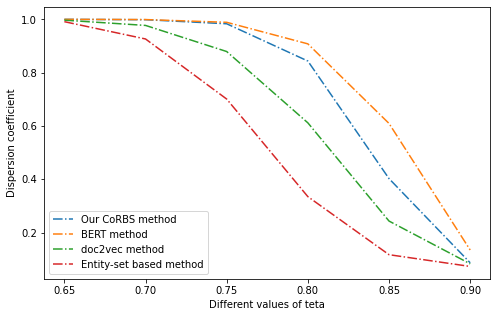

In [ ]:


x = teta_list
plt.figure(figsize=(8,5))





# y = disp_doc2vec_n
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )



y = disp_porposed
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )
y = disp_bert
plt.plot(x, y, label = "BERT method ", linestyle="-." )
y = disp_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )
y = disp_ji
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

plt.xlabel('Different values of teta')
plt.ylabel('Dispersion coefficient')
plt.legend()
plt.show()

In [149]:
def story_evaluation_avg (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return np.average(res)


def story_evaluation_vec (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return res


In [150]:
print('Story Evolution Coefficient (SEC)')
# s_sa = full_story_NYT_proposed_embedding[thre]
# print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_doc2vec_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_ji_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_bert_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
# s_sa = full_story_NYT_doc2vec_embedding_n[0.9]
# print(story_evaluation_avg(s_sa, 0.9))

Story Evolution Coefficient (SEC)
0.4449904353815317
0.3708555731576398
0.6789557007552998


In [ ]:
NYT_proposed = (story_evaluation_vec(full_story_NYT_proposed_embedding[thre], thre))
NYT_doc2vec = (story_evaluation_vec(full_story_NYT_doc2vec_embedding[thre], thre))
# NYT_doc2vec_n = (story_evaluation_vec(full_story_NYT_doc2vec_embedding_n[0.9], 0.9))
NYT_ji = (story_evaluation_vec(full_story_NYT_ji_embedding[thre], thre))
NYT_bert = (story_evaluation_vec(full_story_NYT_bert_embedding[thre], thre))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


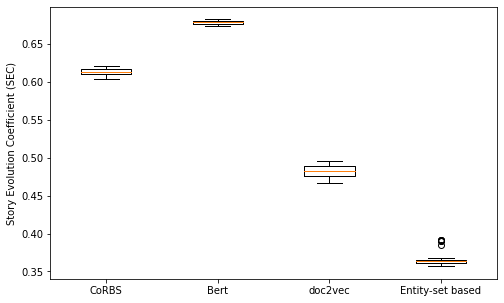

In [ ]:
data = [NYT_proposed, NYT_bert, NYT_doc2vec, NYT_ji]
 
plt.figure(figsize=(8,5))
 
plt.boxplot(data,showfliers=True,labels=['CoRBS','Bert','doc2vec', "Entity-set based"])
plt.ylabel("Story Evolution Coefficient (SEC)")

plt.show()

In [ ]:
import csv
#print stories generated by different models
dict_story_proposed = dict()

c = 0;
for stories in final_results_proposed[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_proposed[c] = temp_doc

for ind in range(1,c+1):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/proposed_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(dict_story_proposed[ind])


In [ ]:

#print stories generated by different models
dict_story_bert = dict()

c = 0;
for stories in final_results_bert[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_bert[c] = temp_doc

for ind in range(1, c+1):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/bert_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(dict_story_bert[ind])

In [ ]:
#print stories generated by different models
dict_story_doc2vec = dict()

c = 0;
for stories in final_results_doc2vec[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_doc2vec[c] = temp_doc

for ind in range(1, c+1):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/doc2vec_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(dict_story_doc2vec[ind])

In [ ]:
#print stories generated by different models
dict_story_ji = dict()

c = 0;
for stories in final_results_ji[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  
  dict_story_ji[c] = temp_doc

for ind in range(1, c+1):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/ji_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(dict_story_ji[ind])

In [ ]:
print(dict_story_ji[1][0][0])
print(dict_story_ji[2][0][0])
print(dict_story_ji[3][0][0])
print(dict_story_ji[4][0][0])
print(dict_story_ji[5][0][0])
print(dict_story_ji[6][0][0])
print(dict_story_ji[7][0][0])
print(dict_story_ji[8][0][0])
print([x[0] for x in final_results_ji[thre]])

250368
268822
223748
244280
233280
246287
239977
254203
[250368, 268822, 223748, 244280, 233280, 246287, 239977, 254203, 245550, 232236, 227942, 255461, 248227, 241798, 234751, 252133, 223319, 237297, 261228, 226552, 255935, 258480, 222927, 247397, 265861, 236285, 222528, 234370, 233415, 243367, 242731, 259867, 223708, 269811, 267859, 249951, 225715, 243608, 241588, 225092, 227069, 240483, 265420, 227162]


In [151]:
def gradient_vector(a_list, n_step):
  b_list = [cosine_similarity([a_list[x]], [a_list[x+1]])[0][0] for x in range(len(a_list)-1) ] 
  n_step = 3
  c_list = [b_list[i:i+n_step] for i in range(len(b_list)-n_step)]
  tmp = list()
  for vec in c_list:
    tmp.append(np.polyfit(np.arange(0, n_step), vec, 1)[0])
  return tmp


In [152]:
# # full_story_NYT_proposed_embedding

# def embedding_derivative_generator(embedding_list):
#   embed_list = [gradient_vector(x, 3) for x in embedding_list]
print(full_story_NYT_proposed_embedding[max_omega])

KeyError: ignored

In [ ]:
NYT_proposed_gradient = [gradient_vector(x, 3) for x in full_story_NYT_proposed_embedding[max_omega]]
NYT_bert_gradient = [gradient_vector(x, 3) for x in full_story_NYT_bert_embedding[max_omega]]
NYT_doc2vec_gradient = [gradient_vector(x, 3) for x in full_story_NYT_doc2vec_embedding[max_omega]]
NYT_ji_gradient = [gradient_vector(x, 3) for x in full_story_NYT_ji_embedding[max_omega]]

In [ ]:
# diff = [x-y for x,y in zip(NYT_proposed_gradient[0], NYT_proposed_gradient[1])]
# diff1 = [x-y for x,y in zip(NYT_proposed_gradient[1], NYT_proposed_gradient[2])]
# print(np.polyfit(np.arange(0, 3), [1, 3, 5], 1)[0])

In [ ]:
# print([x-y for x,y in zip(diff, diff1)])
# t1 =  [np.average(np.absolute(NYT_proposed_gradient[0][i:i+normalized_fac])) for i in range(len(NYT_proposed_gradient[0]))]
# t2 =  [np.average(np.absolute(NYT_proposed_gradient[1][i:i+normalized_fac])) for i in range(len(NYT_proposed_gradient[1]))]
# print(NYT_proposed_gradient[0][0:3])
# print(NYT_proposed_gradient[1][0:3])
# print(NYT_proposed_gradient[2][0:3])
# print(NYT_proposed_gradient[3][0:3])
# print([x-y for x,y in zip(t1,t2)])
for t in range(len(final_results_ji[thre])):
  print(final_results_ji[thre][t])

[250368, 254203, 269811, 265861, 231912, 257385, 257318, 251129, 264013, 228767, 229702, 262726, 263389, 246517, 228221, 223509, 247557, 258205, 223576, 253481, 268931, 224154, 246158, 248942, 264096, 257700, 258490, 241070, 264084, 260586, 246543, 248126, 232458, 222965, 233030, 247325, 257740, 235934, 267718, 244655, 262314, 252739, 246470, 225353, 248726, 223249, 266571, 258272, 239125, 232074, 236122, 233390, 231508, 260872, 232760, 270023, 226276, 256341, 255013, 265695, 231042, 264326, 249091, 230552, 246579, 246656, 234576, 262641, 235477, 257431, 254580, 251257, 230045, 268355, 250989, 266177, 223668, 230664, 253871]
[268822, 255935, 258480, 255461, 227069, 241544, 262074, 257629, 233687, 230072, 227120, 262289, 258676, 243308, 222095, 244757, 243481, 245810, 238085, 229933, 248126, 246543, 232458, 222965, 233030, 247325, 257740, 235934, 267718, 244655, 262314, 252739, 246470, 225353, 248726, 223249, 266571, 258272, 239125, 232074, 236122, 233390, 231508, 260872, 232760, 270023

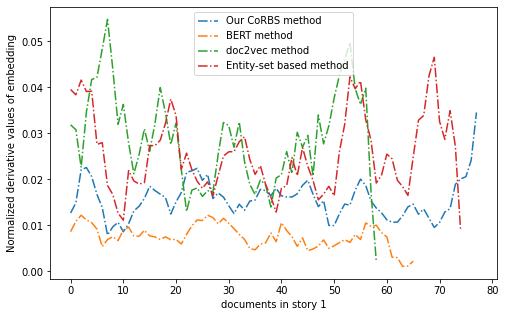

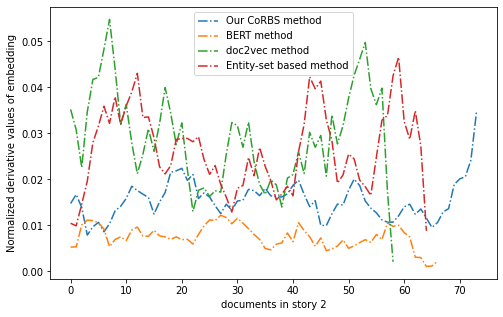

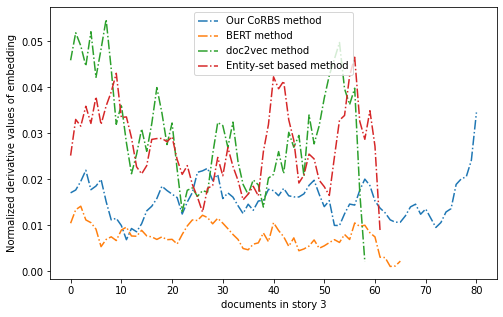

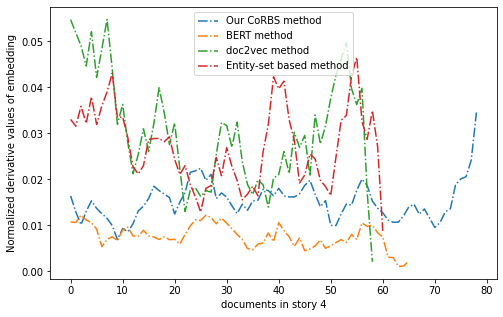

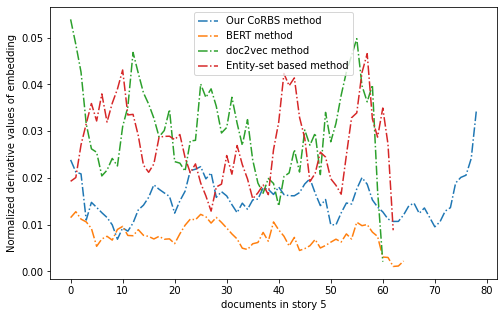

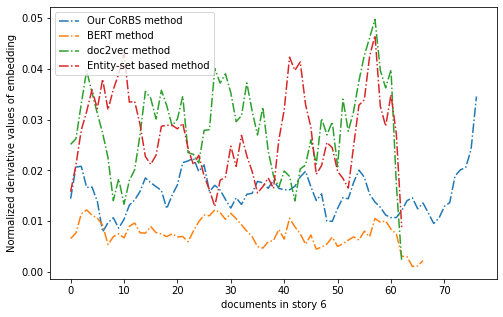

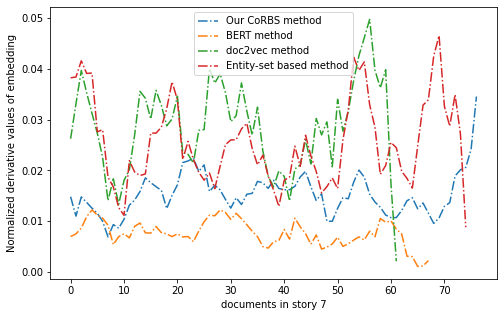

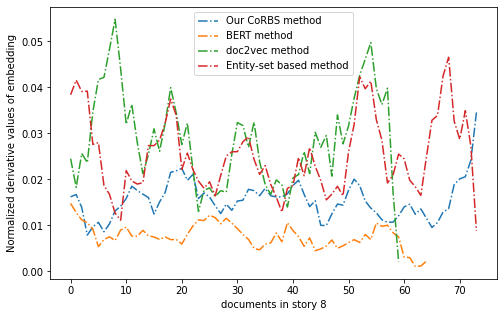

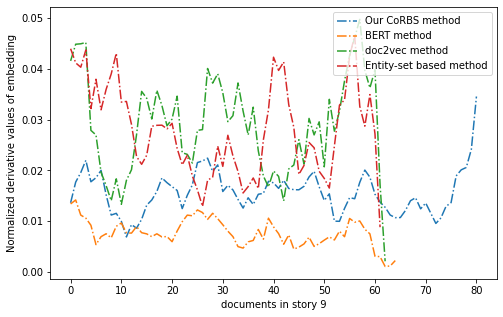

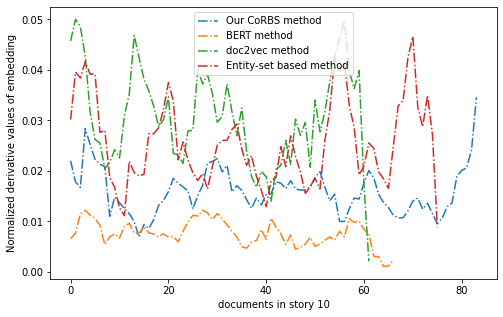

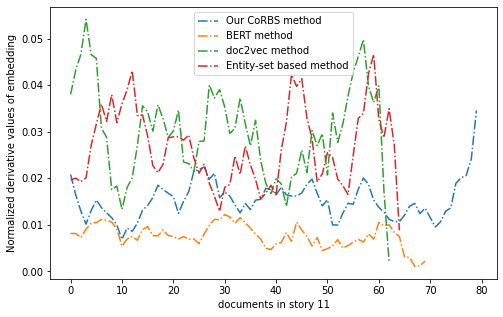

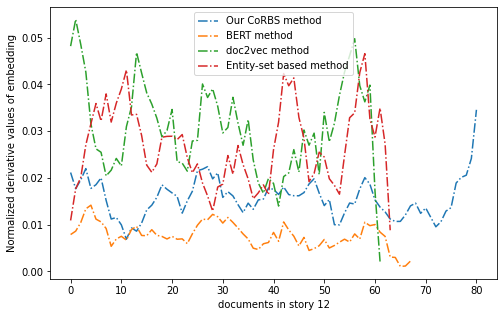

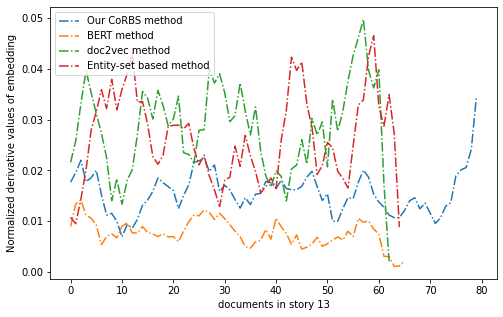

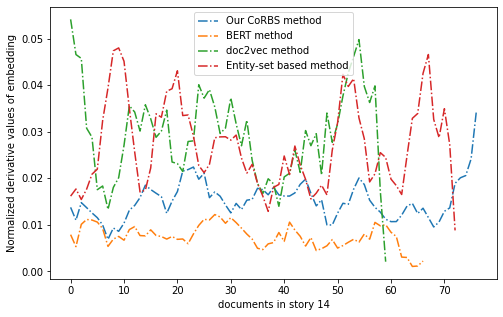

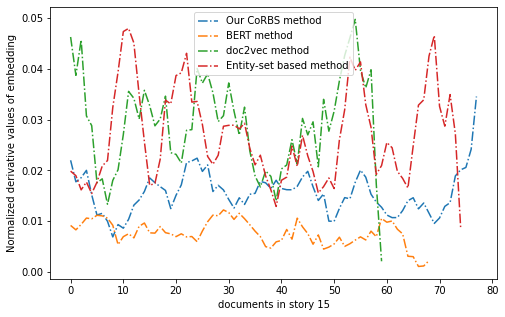

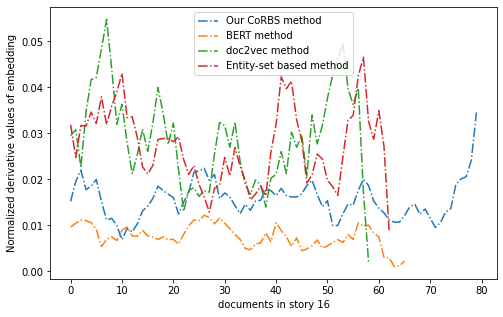

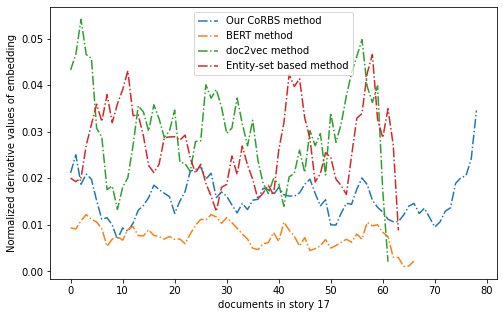

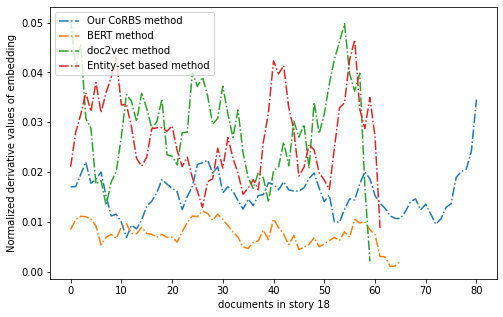

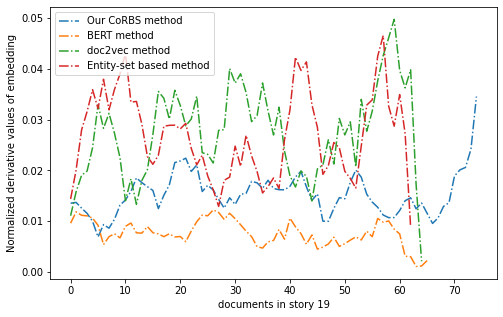

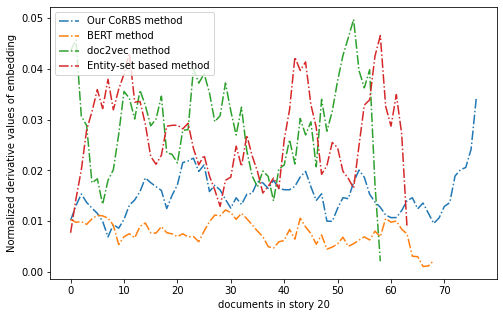

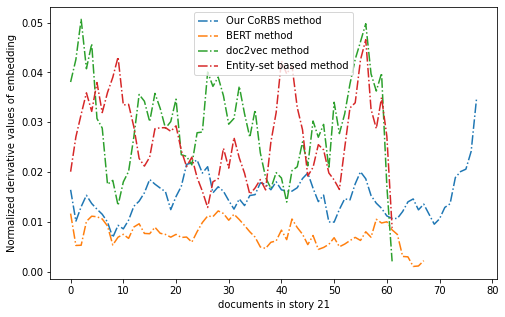

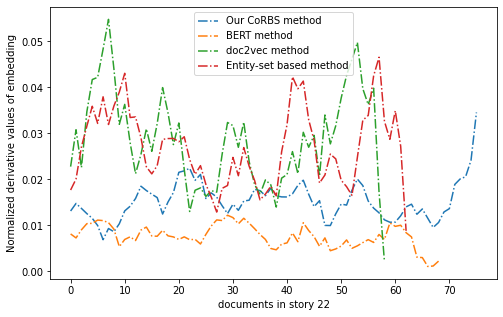

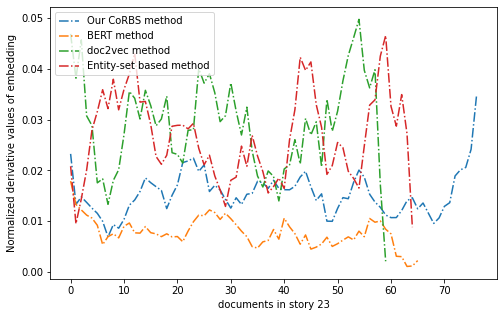

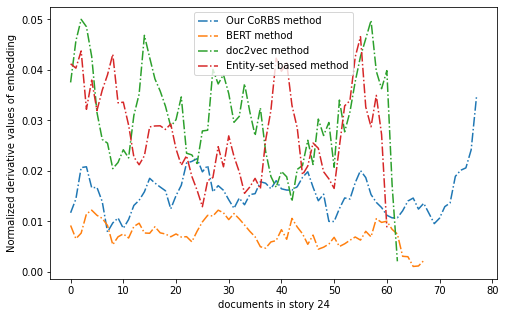

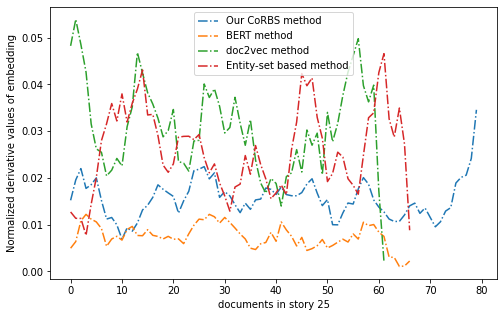

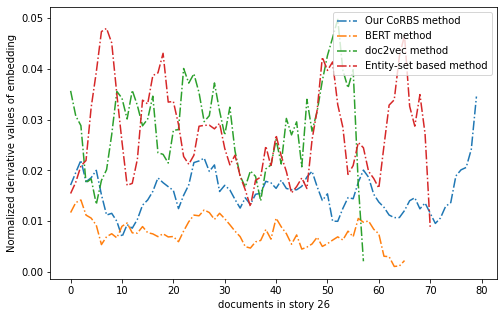

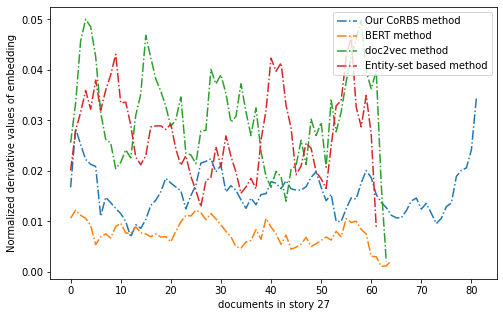

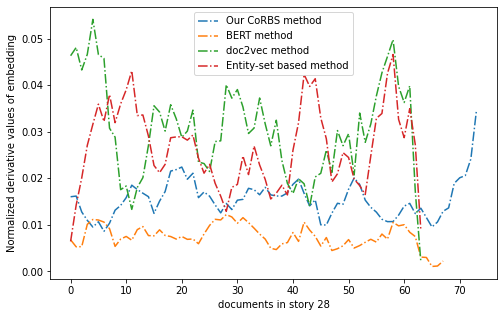

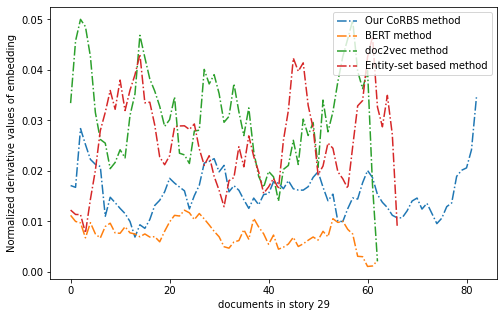

IndexError: ignored

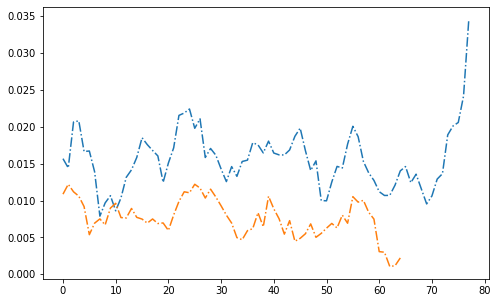

In [ ]:
c = 0
for story_n in range(len(NYT_proposed_gradient)):
  plt.figure(figsize=(8,5))

  # story_n = 2
  c += 1


  # y = disp_doc2vec_n
  # plt.plot(x, y, label = "doc2vec method ", linestyle="-." )
  normalized_fac = 5

  x = [x for x in range(len(NYT_proposed_gradient[story_n]))]
  y = [np.average(np.absolute(NYT_proposed_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_proposed_gradient[story_n]))]
  plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )


  y = [np.average(np.absolute(NYT_bert_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_bert_gradient[story_n]))]
  x = [x for x in range(len(NYT_bert_gradient[story_n]))]
  plt.plot(x, y, label = "BERT method ", linestyle="-." )


  y = [np.average(np.absolute(NYT_doc2vec_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_doc2vec_gradient[story_n]))]
  x = [x for x in range(len(NYT_doc2vec_gradient[story_n]))]
  plt.plot(x, y, label = "doc2vec method ", linestyle="-." )


  y = [np.average(np.absolute(NYT_ji_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_ji_gradient[story_n]))]
  x = [x for x in range(len(NYT_ji_gradient[story_n]))]
  plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

  plt.ylabel('Normalized derivative values of embedding')
  plt.xlabel('documents in story {}'.format(c))
  plt.legend()
  plt.show()


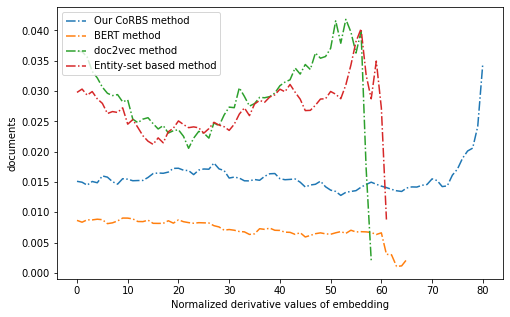

In [ ]:
plt.figure(figsize=(8,5))

story_n = 2



# y = disp_doc2vec_n
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )
normalized_fac = 25

x = [x for x in range(len(NYT_proposed_gradient[story_n]))]
y = [np.average(np.absolute(NYT_proposed_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_proposed_gradient[story_n]))]
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )


y = [np.average(np.absolute(NYT_bert_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_bert_gradient[story_n]))]
x = [x for x in range(len(NYT_bert_gradient[story_n]))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = [np.average(np.absolute(NYT_doc2vec_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_doc2vec_gradient[story_n]))]
x = [x for x in range(len(NYT_doc2vec_gradient[story_n]))]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )


y = [np.average(np.absolute(NYT_ji_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_ji_gradient[story_n]))]
x = [x for x in range(len(NYT_ji_gradient[story_n]))]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

plt.xlabel('Normalized derivative values of embedding')
plt.ylabel('documents')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))

story_n = 6



# y = disp_doc2vec_n
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )
normalized_fac = 25

x = [x for x in range(len(NYT_proposed_gradient[story_n]))]
y = [np.average(np.absolute(NYT_proposed_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_proposed_gradient[story_n]))]
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )


y = [np.average(np.absolute(NYT_bert_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_bert_gradient[story_n]))]
x = [x for x in range(len(NYT_bert_gradient[story_n]))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = [np.average(np.absolute(NYT_doc2vec_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_doc2vec_gradient[story_n]))]
x = [x for x in range(len(NYT_doc2vec_gradient[story_n]))]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )


y = [np.average(np.absolute(NYT_ji_gradient[story_n][i:i+normalized_fac])) for i in range(len(NYT_ji_gradient[story_n]))]
x = [x for x in range(len(NYT_ji_gradient[story_n]))]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

plt.xlabel('Normalized derivative values of embedding')
plt.ylabel('documents')
plt.legend()
plt.show()

### Updated version of StoryGen


In [ ]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict= similarity_generator(dataset)
for doc in Embed_dict.keys():
  min_ = min(Embed_dict[doc].values())
  max_ = max(Embed_dict[doc].values())
  for sec_doc in Embed_dict[doc].keys():
    Embed_dict[doc][sec_doc] = (Embed_dict[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

KeyError: ignored

In [56]:
def special_char_remover(str_):
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

def pre_process(text):
    text = text.lower()
    text = re.sub("", "", text)
    text = re.sub("(\\d|\\W)+", " ", text)
    return text

def stopword_remover(str_, stopwords_):
  words = word_tokenize(str_)
  ps = PorterStemmer()
  temp_list = list()
  for ele in words:
    if ele not in stopwords_:
      temp_list.append(ps.stem(ele))
  return ' '.join(temp_list)

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
  
def jaccard_similarity(text1, text2):
  set_text1 = set(text1)
  set_text2 = set(text2)
  return len(set_text1.intersection(set_text2)) / len(set_text1.union(set_text2))

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results
  
data_content = dict()
for index, row in df.iterrows():
  data_content[row['id']] = stopword_remover(pre_process(special_char_remover(row['content'])), stopwords)

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)
word_count_vector = cv.fit_transform(data_content.values())
tfidf_transformer.fit(word_count_vector)
feature_names = cv.get_feature_names_out()


top_keywords = dict()
for ind, doc in data_content.items():
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  keywords = extract_topn_from_vector(feature_names,sorted_items,100)

  temp_list = dict()
  for k, val in keywords.items():
    temp_list[k] = int(20* val)
  top_keywords[ind] = temp_list

In [57]:
def weighted_jaccard_sim (top_keywords_):
  total_doc = dict()
  for doc in top_keywords_.keys():
    temp_list = list()
    for key_, val_ in top_keywords_[doc].items():
      for i in range(val_):
        temp_list.append(key_)


    total_doc[doc] = temp_list
  return total_doc

In [58]:
total_doc_tf_idf = weighted_jaccard_sim(top_keywords)
# print(weights[248238][264005])
# print(weights[248238][253155])
final_jaccard_docs = dict()
for doc1 in tqdm(total_doc_tf_idf.keys()):
  temp_dict = dict()
  for doc2 in total_doc_tf_idf.keys():
    temp_dict[doc2] = jaccard_similarity(total_doc_tf_idf[doc1], total_doc_tf_idf[doc2])
  final_jaccard_docs[doc1] = temp_dict
  



100%|██████████| 1154/1154 [00:17<00:00, 64.38it/s]


In [59]:
print(final_jaccard_docs[248238][264005]) # 1 means they are more similarity, zero means there is no entity overlap
print(final_jaccard_docs[248238][253155])
print(len(top_keywords[237366]))

0.14705882352941177
0.011976047904191617
100


In [60]:
def post_processing(list_of_doc):
  start_story = list_of_doc[0]
  story_line = list()
  keywords_ = list(top_keywords[start_story].keys())[0:20]

  for doc_ in list_of_doc:
    sco = 0
    for el_ in keywords_:
      if el_ in top_keywords[doc_].keys():
        sco += 1
    if sco > 6:
      story_line.append(doc_)
  return story_line


In [61]:
# seed_doc = [234370, 241335, 247617, 261228, 229985, 240208, 250368, 264013, 251129, 235807, 264005, 271040, 247094, 269407, 237358, 246287, 238686, 271528, 261532, 232858, 225564, 246386,
#             239548, 252517, 229305, 267644, 248238, 264005, 248722, 271361, 250707]


def story_selector(pre_story, story_candidate, jaccard_docs, min_similary_criteria):
  max_val = 0
  id_ = -1
  for doc in story_candidate:
    z = jaccard_docs[doc[0]][pre_story]
    if  z > max_val:
      max_val = z
      id_ = doc[0]
  if max_val > min_similary_criteria:
    return id_
  else:
    return -1

In [71]:
#new storyGe for the proposed method - for the case study
#find ts of a story
# id_ = 234370
# c = 0
# for d in timestamps:
#   if id_ in d:
#     print(c)
#   c += 1
def timestamp_finder (id_, timestamps):
  for i in range(len(timestamps)):
    if id_ in timestamps[i]:
      return i

def final_story_generator(context_list, keyword_dict, threshold):
  final_l = list()
  final_l.append(context_list[0])
  for sto in context_list[1:]:
    if keyword_dict[final_l[-1]][sto] < threshold:
      final_l.append(sto)
  return final_l

def story_generator_a(weights, timestamps, start_doc, min_omega, max_omega):
  ban_list = [244757]
  cur_ts = 0
  new_story = list()
  cur_story = start_doc
  

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story and el not in ban_list:
        temp_dict[el] = weights[cur_story][el]
    res = min_from_dict(temp_dict, min_omega, max_omega)
    if res[1] == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res[1])
      for checker in range(len(timestamps)):
        if res[1] in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res[1]
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story

def story_generator_top_k(weights, timestamps, start_doc, min_omega, max_omega, top_k):
  ban_list = [244757]
  cur_ts = 0
  new_story = list()
  cur_story = start_doc

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story and el not in ban_list:
        # print(cur_story , ' ' ,el)
        temp_dict[el] = weights[cur_story][el]
    res = mins_from_dict(temp_dict, min_omega, max_omega)
    res = res if len(res) < top_k else res[:top_k]
    try:
      res_ = story_selector(new_story[-1], res, final_jaccard_docs, 0.03) # first argumant is a list of stories, the second one is the criteria
    except:
      cur_ts +=1
      break
    # if res[1] == -1: # the minimum based on the values is not find
    #   cur_ts +=1
    #   break
    if res_ == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res_)
      for checker in range(len(timestamps)):
        if res_ in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res_
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story



In [173]:
start_ts = 0
seed_documents = timestamps[start_ts]
min_omega = 0
max_omega = 0
seed_doc = [239400,  240581, 247617, 250606, 239548, 236323, 229230, 247481,  226242, 230007, 232746, 254293, 223376, 265861, 264084, 226175, 261950, 254227]
seed_documents = seed_doc
stories_top_k = dict()

for k in [50, 40, 30, 20, 10, 5, 3, 1]:
  print(' k = {}'.format(k))
  list_of_story_proposed = list()
  list_of_story_bert = list()
  list_of_story_doc2vec = list()
  list_of_story_ji = list()

  for se in seed_documents:
    list_of_story_proposed.append(post_processing(story_generator_top_k(weights, timestamps[timestamp_finder(se, timestamps):], se, 0, 1, k)))
    list_of_story_bert.append(post_processing(story_generator_top_k(dict_similarity_bert_cls_docs,timestamps[timestamp_finder(se, timestamps):], se, 0, 1, k)))
    list_of_story_doc2vec.append(post_processing(story_generator_top_k(Embed_dict_doc2vec, timestamps[timestamp_finder(se, timestamps):], se, 0, 1, k)))
    list_of_story_ji.append(post_processing(story_generator_top_k(Embed_dict, timestamps[timestamp_finder(se, timestamps):], se, 0, 1, k)))

  stories_top_k[k] = [list_of_story_proposed, list_of_story_bert, list_of_story_doc2vec, list_of_story_ji]
  for story_n in range(len(seed_documents)):
    print('-----------------------Story number {}-----------------------------------'.format(story_n + 1))
    print('proposed method: ')
    for doc_id in list_of_story_proposed[story_n]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('bert method: ')
    for doc_id in list_of_story_bert[story_n]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('doc2vec method: ')
    for doc_id in list_of_story_doc2vec[story_n]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('Entity-set based method: ')
    for doc_id in list_of_story_ji[story_n]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')

  print('\n\n')

 k = 50
-----------------------Story number 1-----------------------------------
proposed method: 
239400 ,  0101 ,   Republican Attacks on Mueller and F.B.I. Open New Rift in G.O.P.  
241335 ,  0104 ,   Paul Manafort Sues Mueller and Asks a Judge to Narrow the Russia Investigation  
239977 ,  0111 ,   Gillibrand Vows to Block Trump s Likely Choice for U.S. Attorney in Manhattan  
261228 ,  0111 ,   Trump Sidesteps Question on Mueller Interview  
247517 ,  0127 ,   Senate Democrats Seek to Protect Mueller From Being Fired  
256501 ,  0129 ,   Republicans Show Little Urgency on Legislation to Protect Mueller  
254144 ,  0201 ,   From   New American Moment  to Same Partisan Rancor  
258583 ,  0204 ,   Trump Says Republican Memo   Totally Vindicates  Him  
255475 ,  0203 ,   House Republicans Release Secret Memo Accusing Russia Investigators of Bias  
261196 ,  0204 ,   How Trump s Allies Fanned an Ember of Controversy Into Flames of Outrage  
266389 ,  0206 ,   Committee Votes to Release

In [184]:
# pickle.dump(stories_top_k, open('drive/MyDrive/temp/data_last_version/ stories_top_k.p', 'wb'))
print(len(stories_top_k[50][0]))
print(len(stories_top_k[top_k]))

18
4


In [187]:
stories_top_k
for story_id in range(len(stories_top_k[50][0])):
  for top_k in [50, 40, 30, 20, 10, 5, 3, 1]:
    print('CoRBS method: ')
    for doc_id in stories_top_k[top_k][0][story_id]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('Bert method: ')
    for doc_id in stories_top_k[top_k][1][story_id]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('doc2vec method: ')
    for doc_id in stories_top_k[top_k][2][story_id]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')
    print('Entity-set based method: ')
    for doc_id in stories_top_k[top_k][3][story_id]:
      temp = df[df['id'] == doc_id]
      print(str(temp['id'].values[0]), ', ', str(temp['publish_time'].values[0])[0:4], ',  ',str(temp['title'].values[0]))
    print('---------------------------------------------------------------------------')




CoRBS method: 
239400 ,  0101 ,   Republican Attacks on Mueller and F.B.I. Open New Rift in G.O.P.  
241335 ,  0104 ,   Paul Manafort Sues Mueller and Asks a Judge to Narrow the Russia Investigation  
239977 ,  0111 ,   Gillibrand Vows to Block Trump s Likely Choice for U.S. Attorney in Manhattan  
261228 ,  0111 ,   Trump Sidesteps Question on Mueller Interview  
247517 ,  0127 ,   Senate Democrats Seek to Protect Mueller From Being Fired  
256501 ,  0129 ,   Republicans Show Little Urgency on Legislation to Protect Mueller  
254144 ,  0201 ,   From   New American Moment  to Same Partisan Rancor  
258583 ,  0204 ,   Trump Says Republican Memo   Totally Vindicates  Him  
255475 ,  0203 ,   House Republicans Release Secret Memo Accusing Russia Investigators of Bias  
261196 ,  0204 ,   How Trump s Allies Fanned an Ember of Controversy Into Flames of Outrage  
266389 ,  0206 ,   Committee Votes to Release Democratic Rebuttal to G.O.P. Russia Memo  
226858 ,  0207 ,   Senate Letter Echoes

In [ ]:
#geerate wordCould for the paper


story_nyt_proposed_entity_overlap = pickle.load(open('drive/MyDrive/temp/data_last_version/story_nyt_proposed_entity_overlap.p', 'rb'))
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']








for story_ in story_nyt_proposed_entity_overlap:
  print('--------------------------------------------')
  print('--------------------------------------------')
  print('--------------------------------------------')
  for doc_ in story_:
    print('top keywords for doc {}'.format(doc_))
    print(top_keywords[doc_].keys())
    temp_df = df[df['id']==doc_]
    print(temp_df['publish_time'].values[0], ', ', temp_df['title'].values[0])












--------------------------------------------
--------------------------------------------
--------------------------------------------
top keywords for doc 234370
dict_keys(['dmitriev', 'stalin', 'sandormokh', 'psychiatr', 'photograph', 'memori', 'pornographi', 'historian', 'russia', 'past', 'moscow', 'victim', 'test', 'decemb', 'yuri', 'stalinist', 'sovietera', 'pornograph', 'natalya', 'karelia', 'gulag', 'chapel', 'afoul', 'expert', 'ruffl', 'remembr', 'nikita', 'khrushchev', 'offici', 'unearth', 'monument', 'emphasi', 'commun', 'nake', 'year', 'wooden', 'pride', 'honest', 'feather', 'attitud', 'court', 'took', 'oldest', 'aug', 'purg', 'northwestern', 'famous', 'undergo', 'soviet', 'pit', 'buri', 'grave', 'chapter', 'detent', 'dictat', 'devot', 'seemingli', 'kremlin', 'communist', 'toler', 'dedic', 'convict', 'beat', 'labor', 'take', 'denounc', 'camp', 'pictur', 'mr', 'respect', 'ran', 'murder', 'appar', 'transform', 'adopt', 'jan', 'celebr', 'encourag', 'nine', 'search', 'child', 'd

In [ ]:
#display the wordCloud
total_doc = dict()
for story_ in story_nyt_proposed_entity_overlap:
  for doc_ in story_:
    temp = list()
    for word_ in top_keywords[doc_].keys():
      for rep in range(top_keywords[doc_][word_]):
        temp.append(word_)
    total_doc[doc_] = ' '.join(temp)



# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in story_nyt_proposed_entity_overlap:
  print('---------------------------------------')
  print('New Story ', story)
  for doc in story:
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(total_doc[doc])
    print('---------- {} ------------'.format(story))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print()

In [ ]:

# print(timestamp_finder(seeds_[4], timestamps))

#generate stories by other models
seeds_ = [f[0] for f in story_nyt_proposed_entity_overlap]

# by JI
story_JI = list()
story_bert = list()
story_doc2vec = list()
for se in seeds_:
  min_omega = 0.77
  max_omega = 0.82
  story_JI.append(story_generator(Embed_dict, timestamps[timestamp_finder(se, timestamps):], se  , min_omega , max_omega))
  min_omega = 0.71
  max_omega = 0.92
  story_bert.append(story_generator(dict_similarity_bert_cls_docs,timestamps[timestamp_finder(se, timestamps):], se, min_omega , max_omega))
  min_omega = 0.36
  max_omega = 0.42
  story_doc2vec.append(story_generator(Embed_dict_doc2vec, timestamps[timestamp_finder(se, timestamps):], se, min_omega, max_omega))



print([len(f) for f in story_nyt_proposed_entity_overlap])
print([len(f) for f in story_JI])
print([len(f) for f in story_bert])
print([len(f) for f in story_doc2vec])

[4, 5, 6, 2, 8, 2, 3, 8, 4]
[7, 3, 8, 3, 2, 10, 9, 2, 8]
[7, 3, 2, 4, 3, 8, 7, 8, 7]
[8, 19, 9, 4, 1, 9, 15, 11, 10]


In [ ]:
def cos_sim(list_a):
  return [cosine_similarity([list_a[a]], [list_a[a+1]])[0][0] for a in range(len(list_a)-1)]

In [ ]:
#generate embedding for each story by each model
corbs_story_list = list()
for story in story_nyt_proposed_entity_overlap:
  temp_list = list()
  for doc in story:
    temp_list.append(total_doc_embedding_cls[doc])
  corbs_story_list.append(temp_list)
corbs_story_list = [cos_sim(a) for a in corbs_story_list]


bert_story_list = list()
for story in story_bert:
  temp_list = list()
  for doc in story:
    temp_list.append(total_doc_embedding_cls[doc])
  bert_story_list.append(temp_list)
bert_story_list = [cos_sim(a) for a in bert_story_list]


doc2vec_story_list = list()
for story in story_doc2vec:
  temp_list = list()
  for doc in story:
    temp_list.append(total_doc_embedding_cls[doc])
  doc2vec_story_list.append(temp_list)
doc2vec_story_list = [cos_sim(a) for a in doc2vec_story_list]


ji_story_list = list()
for story in story_JI:
  temp_list = list()
  for doc in story:
    temp_list.append(total_doc_embedding_cls[doc])
  ji_story_list.append(temp_list)
ji_story_list = [cos_sim(a) for a in ji_story_list]

c = 0
for story_n in range(len(story_nyt_proposed_entity_overlap)):
  plt.figure(figsize=(8,5))

  # story_n = 2
  



  x = [x for x in range(len(corbs_story_list[story_n]))]
  y = corbs_story_list[story_n]
  plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )


  y =bert_story_list[story_n]
  x = [x for x in range(len(bert_story_list[story_n]))]
  plt.plot(x, y, label = "BERT method ", linestyle="-." )


  y = doc2vec_story_list[story_n]
  x = [x for x in range(len(doc2vec_story_list[story_n]))]
  plt.plot(x, y, label = "doc2vec method ", linestyle="-." )


  y =ji_story_list[story_n]
  x = [x for x in range(len(ji_story_list[story_n]))]
  plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

  plt.ylabel('cosine similarity')
  plt.xlabel('documents in story {}'.format(c))
  plt.legend()
  plt.show()
  c += 1


In [ ]:
#generate embedding for each story by each model
# Embed_dict

corbs_story_entity = list()
for story in story_nyt_proposed_entity_overlap:
  corbs_story_entity.append([Embed_dict[story[a]][story[a+1]] for a in range(len(story)-1)])


bert_story_entity = list()
for story in story_bert:
  bert_story_entity.append([Embed_dict[story[a]][story[a+1]] for a in range(len(story)-1)])


doc2vec_story_entity = list()
for story in story_doc2vec:
  doc2vec_story_entity.append([Embed_dict[story[a]][story[a+1]] for a in range(len(story)-1)])


ji_story_entity = list()
for story in story_JI:
  ji_story_entity.append([Embed_dict[story[a]][story[a+1]] for a in range(len(story)-1)])



c = 0
for story_n in range(len(story_nyt_proposed_entity_overlap)):
  plt.figure(figsize=(8,5))

  # story_n = 2
  



  x = [x for x in range(len(corbs_story_entity[story_n]))]
  y = corbs_story_entity[story_n]
  plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )


  y =bert_story_entity[story_n]
  x = [x for x in range(len(bert_story_entity[story_n]))]
  plt.plot(x, y, label = "BERT method ", linestyle="-." )


  y = doc2vec_story_entity[story_n]
  x = [x for x in range(len(doc2vec_story_entity[story_n]))]
  plt.plot(x, y, label = "doc2vec method ", linestyle="-." )


  y =ji_story_entity[story_n]
  x = [x for x in range(len(ji_story_entity[story_n]))]
  plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

  plt.ylabel('entity overlap')
  plt.xlabel('documents in story {}'.format(c))
  plt.legend()
  plt.show()
  c += 1


In [ ]:
for i in range(len(story_nyt_proposed_entity_overlap)):
  print('------------------------------------------')
  print('------------story {}---------------------'.format(i+1))
  print('------------------------------------------')
  print('story generated by CoRBS model')
  for doc in story_nyt_proposed_entity_overlap[i]:
    temp = df[df['id']== doc]
    print (temp['id'].values[0], ', ', temp['publish_time'].values[0], ', ', temp['title'].values[0])
  print('------------------------------------------')
  print('story generated by Bert model')
  for doc in story_bert[i]:
    temp = df[df['id']== doc]
    print (temp['id'].values[0], ', ', temp['publish_time'].values[0], ', ', temp['title'].values[0])
  print('------------------------------------------') 
  print('story generated by doc2vec model')
  for doc in story_doc2vec[i]:
    temp = df[df['id']== doc]
    print(temp['id'].values[0], ', ', temp['publish_time'].values[0], ', ', temp['title'].values[0])
  print('------------------------------------------')
  print('story generated by Entity-based set model')
  for doc in story_JI[i]:
    temp = df[df['id']== doc]
    print (temp['id'].values[0], ', ', temp['publish_time'].values[0], ', ', temp['title'].values[0])




------------------------------------------
------------story 1---------------------
------------------------------------------
story generated by CoRBS model
234370 ,  01122018 ,  Gulag Historian Ordered to Undergo Psychiatric Testing in Russia  
244757 ,  01282018 ,  Czech Republic Re-elects Milos Zeman, Populist Leader and Foe of Migrants  
229658 ,  02052018 ,  Thousands of ISIS Fighters Flee in Syria, Many to Fight Another Day  
237048 ,  03082018 ,  Gary Cohn, Jeff Sessions, Russia: Your Wednesday Evening Briefing  
------------------------------------------
story generated by Bert model
234370 ,  01122018 ,  Gulag Historian Ordered to Undergo Psychiatric Testing in Russia  
252133 ,  01112018 ,  Surveillance and Privacy Debate Reaches Pivotal Moment in Congress  
245550 ,  01112018 ,  How I Approached a Story About the Homeless  
227162 ,  01122018 ,  What You Need to Do Because of Flaws in Computer Chips  
239977 ,  01112018 ,  Gillibrand Vows to Block Trump s Likely Choice for 